# Машинное обучение в задачах метеорологии

Данный ноутбук разработан для предсказания метеопараметров. Картинки будут сохраняться в папке `pics` в директории ноутбука.

### Загрузка необходимых библиотек

In [50]:
import tensorflow as tf
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import shap
import warnings

import os
from datetime import datetime as dt
from IPython.display import Image, HTML
import IPython                            #Модуль отображения
import IPython.display

import geopy
from geopy.distance import geodesic

from sklearn import neighbors

import datetime
import time

from sklearn.decomposition import PCA
from scipy import interpolate

%load_ext tensorboard

import skdim

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Импорт класса MeteoStations

In [51]:
from MeteoStationsClass import *

### Инициализация элемента класса через excel файл

In [52]:
souceFile = 'new_stations.xlsx'
M1 = MeteoStations(souceFile)


In [53]:
# Выгрузка индексов и координат

Lats=M1.DataFrame['LAT']# Latitudes
Lons=M1.DataFrame['LON']# Longitudes



Indexes=np.array(M1.DataFrame.index)
print('всего станций:',Indexes.shape)
# print(Indexes)

всего станций: (121,)


### Запуск процедуры поиска k соседей

In [54]:
M1.findNeighbours(k=5)

### Визуализация станции "Михайловск" и кластера, образованного её соседями

In [55]:
M1.plotNeighbours(M1.getIndexByName('Михайловск'))

### Вывод информации по кластеру "Михайловск"

In [56]:
M1.Neighbours(M1.getIndexByName('Михайловск')) # M1.Neighbours(34949)

Name  Distance, km     LAT     LON MeteoData
index                                                      
34949    Михайловск      0.000000  45.109  42.113      None
34945    ИЗОБИЛЬНЫЙ     43.507884  45.370  41.700      None
37036  НЕВИННОМЫССК     54.141091  44.633  41.967      None
34954    СВЕТЛОГРАД     63.774252  45.350  42.850      None
37031       АРМАВИР     79.707636  44.983  41.117      None

In [57]:
M1.Neighbours(M1.getIndexByName('Михайловск')).index.to_list()

[34949, 34945, 37036, 34954, 37031]

In [58]:
M1.loadMeteoData(stationsInd=M1.Neighbours(M1.getIndexByName('Михайловск')).index.to_list(),loadPath='CSVProcessed',prefix=True, forced=True)

In [59]:
M1.loadMeteoData(loadPath='CSVProcessed',prefix=True, forced=True)

In [60]:
usefulDF = M1.MeteoDf

### Описание метеоданных

### Поиск пространственных мод с помощью DAPCA

In [61]:
# Ячейка предобработки
Type='ff3' # Что анализировать (из списка выше)

useN=24000

PoData=[]
Lens=[]
Index2=[]



for indx in Indexes:
    tmp=np.array(usefulDF[indx][Type+'_'+str(indx)])
    nulls=[]
    for i in range(0,tmp.shape[0]):
        if (math.isnan(tmp[i])):
            nulls.append(i)
    if len(nulls)!=0:
        tmp=np.delete(tmp,nulls)
#             print('nan',indx,i)
            
    
    if (tmp.shape[0])>6000: 
        useArg=np.linspace(0,tmp.shape[0]-1,useN)
        tmp2=interpolate.interp1d(np.arange(0,tmp.shape[0]),tmp,kind='linear')(useArg)
        PoData.append(tmp2)
        Lens.append(tmp2.shape[0])
        Index2.append(indx)
PoData=np.array(PoData)

In [62]:
PoData.shape

(106, 24000)

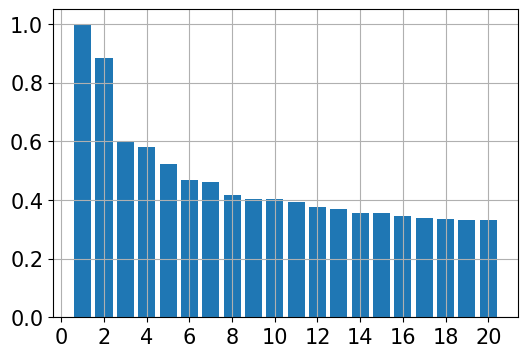

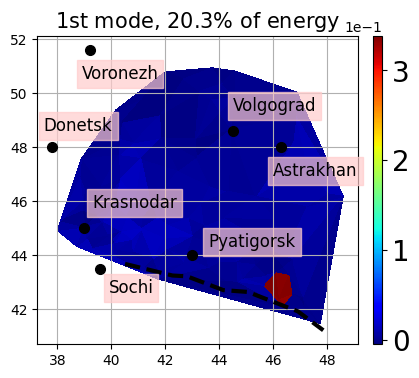

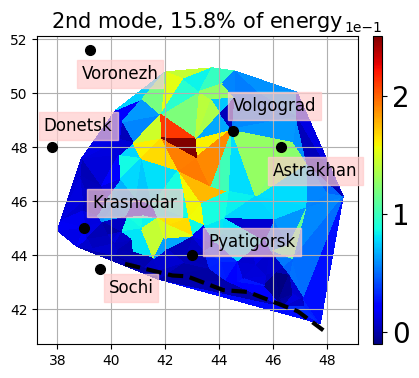

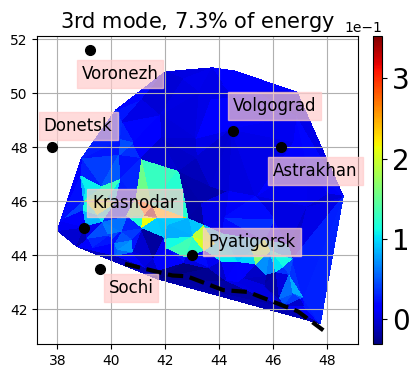

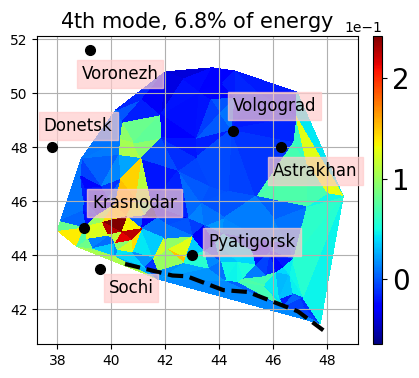

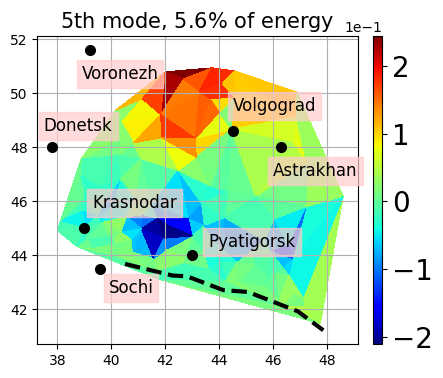

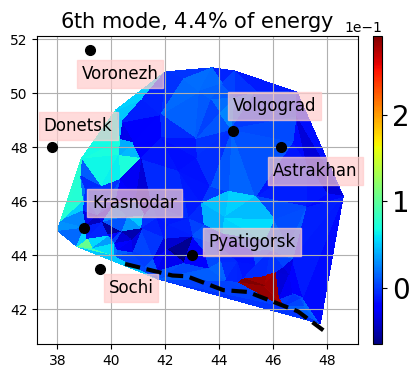

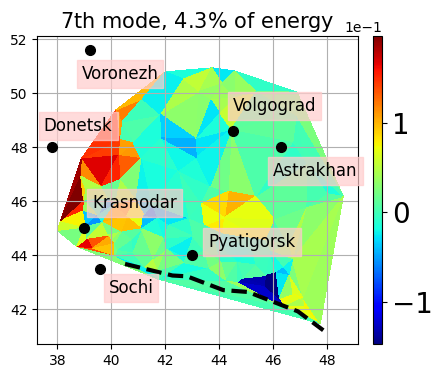

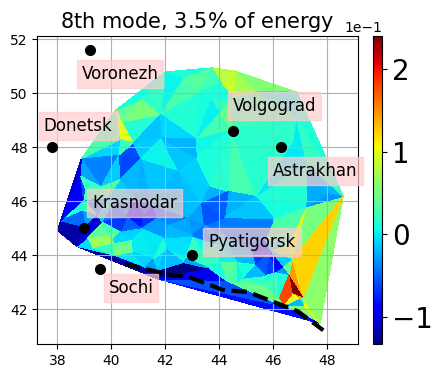

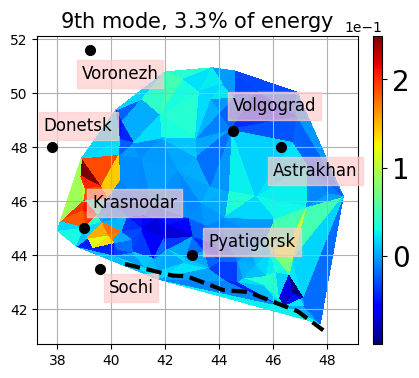

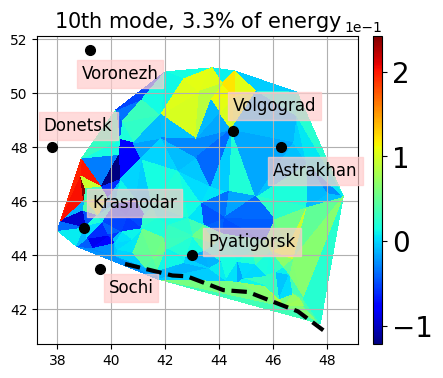

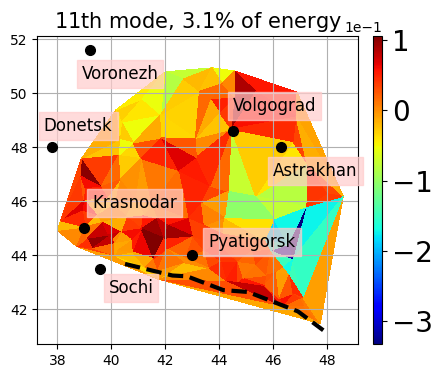

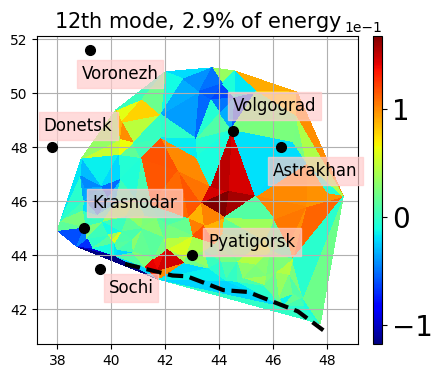

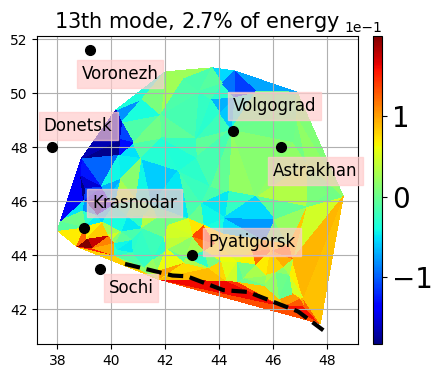

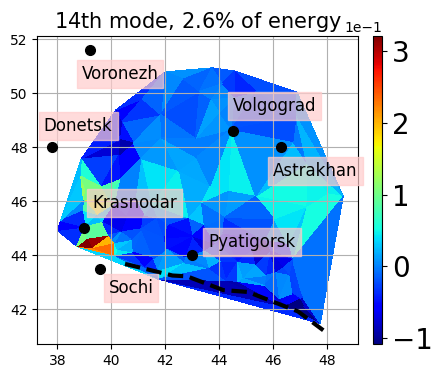

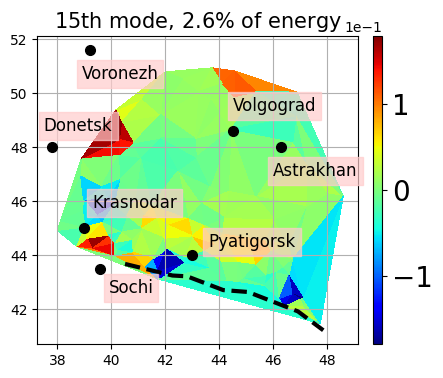

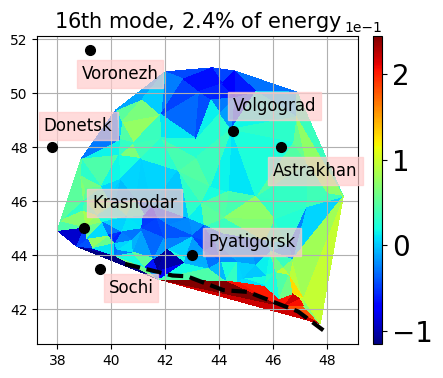

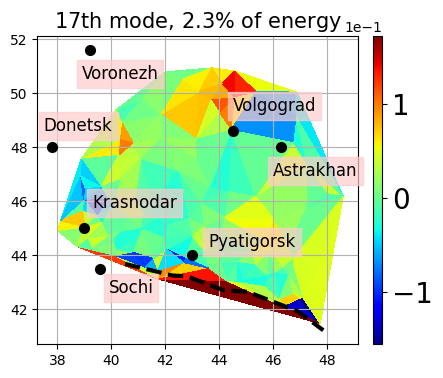

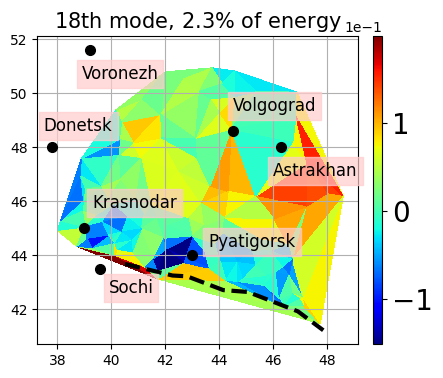

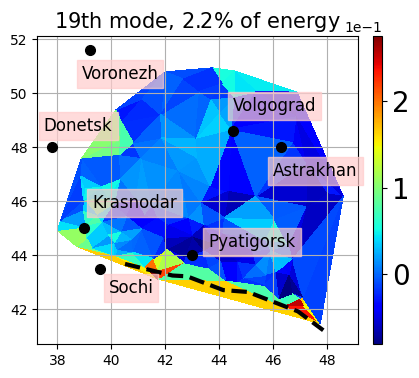

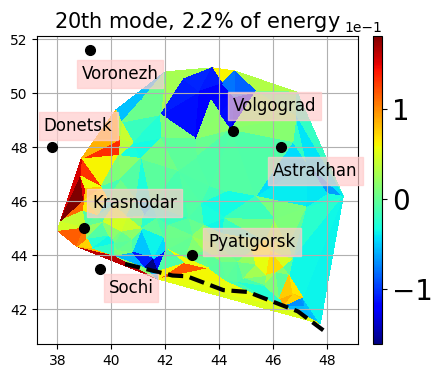

5.9 s for DAPCA


In [63]:
# DAPCA
nComp=20 # number of modes to consider
ifsave=True # Сохранение (в папку [This_notebook_dir]/pics/[Typename]
dnx=int (nComp/10) # шаг для столбчатой диаграммы. Можно регулировать

exec(open(os.path.join(os.path.abspath(os.curdir),"source","DAPCA.py")).read()) # Путь к DAPCA!!!
warnings.filterwarnings('ignore')

XXX=PoData.T


dpi=300

LatData=[]
LonData=[]

for ind in Index2:
    LatData.append(Lats[ind])
    LonData.append(Lons[ind])


from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# import matplotlib as mpl

if (ifsave):
    hDir=os.path.join(os.path.abspath(os.curdir),"pics")
    if (not os.path.exists(hDir)):
        os.mkdir(hDir)
    iDir=Type+str(nComp)+'comp'
    if (not os.path.exists(hDir+'/'+iDir)):
        os.mkdir(hDir+'/'+iDir)
    else:
        dir = hDir+'/'+iDir
        for f in os.listdir(dir):
            os.remove(os.path.join(dir, f))


labels=np.zeros(XXX.shape[0])

t00=time.time()

K=2 # segments for artificial labels creation (doesn't influence on the result)
inxl=[0]
for i in range(1,K):
    inxl.append(int(i*labels.shape[0]/K))
inxl.append(labels.shape[0])
# print (inxl)
for i in range(0,np.size(inxl)-1):
    for j in range(inxl[i],inxl[i+1]): labels[j]=i
#print(labels)
[V, D, PX, PY, kNNs] = DAPCA(XX=XXX, labels=labels, YY=None, nComp=nComp)

plt.figure(figsize=[6,4])

plt.bar(np.arange(D.shape[0])+1,(abs(D)/np.max(abs(D)))**0.5)

plt.xticks(np.arange(D.shape[0]+1)[::dnx],fontsize=15);plt.yticks(fontsize=15)
plt.grid(True)
if ifsave:
    plt.savefig(hDir+'/'+iDir+'/eigenvalues.png',dpi=dpi,bbox_inches='tight')
plt.show()

for i in range(0,nComp):
    plt.figure(figsize=[6,4])
#     mpl.rcParams['figure.dpi'] = 60

    plt.tripcolor(LonData,LatData,V[:,i],cmap='jet')
    ax=plt.gca();ax.set_aspect('equal')
    if i==0:
            appendix='st'
    elif i==1:
        appendix='nd'
    elif i==2:
        appendix='rd'
    else:
        appendix='th'
    plt.title(str(i+1)+appendix+' mode, {:.1f}$\%$ of energy'.format(100*D[i]/np.sum(D)),fontsize=15)
    
    
    ms=7
    hs=0.3
    
    # Plotting of several cities (manually)
    
    # Volgograd
    
    plt.text(44.5,48.6+2.5*hs,'Volgograd',size='large',bbox=dict(boxstyle="square",
                   ec=(1., 0.8, 0.8),
                   fc=(1., 0.8, 0.8),alpha=0.7
                   ));     plt.plot([44.5],[48.6],'ok',markersize=ms)
    
    # Voronezh
    plt.text(39.2-hs,51.6-3.5*hs,'Voronezh',size='large',bbox=dict(boxstyle="square",
                   ec=(1., 0.8, 0.8),
                   fc=(1., 0.8, 0.8),alpha=0.7
                   ));plt.plot([39.2],[51.6],'ok',markersize=ms)
    
    # Donetsk
    plt.text(37.8-hs,48+2*hs,'Donetsk',size='large',bbox=dict(boxstyle="square",
                   ec=(1., 0.8, 0.8),
                   fc=(1., 0.8, 0.8),alpha=0.7
                   ));plt.plot([37.8],[48],'ok',markersize=ms)
    
    # Pyatigorsk
    plt.plot([43],[44],'ok',markersize=ms)
    plt.text(43+2*hs,44+hs,'Pyatigorsk',size='large',bbox=dict(boxstyle="square",
                   ec=(1., 0.8, 0.8),
                   fc=(1., 0.8, 0.8),alpha=0.7
                   ))
    
    # Astrakhan
    plt.plot([46.3],[48],'ok',markersize=ms)
    plt.text(46.3-hs,48-3.5*hs,'Astrakhan',size='large',bbox=dict(boxstyle="square",
                   ec=(1., 0.8, 0.8),
                   fc=(1., 0.8, 0.8),alpha=0.7
                   ))
    
    # Krasnodar
    plt.plot([39],[45],'ok',markersize=ms)
    plt.text(39+hs,45+2.5*hs,'Krasnodar',size='large',bbox=dict(boxstyle="square",
                   ec=(1., 0.8, 0.8),
                   fc=(1., 0.8, 0.8),alpha=0.7
                   ))
    
    # Sochi
    plt.plot([39.6],[43.5],'ok',markersize=ms)
    plt.text(39.6+hs,43.5-3*hs,'Sochi',size='large',bbox=dict(boxstyle="square",
                   ec=(1., 0.8, 0.8),
                   fc=(1., 0.8, 0.8),alpha=0.7
                   ))
    
    # Caucasus range
    plt.plot([40.51,42.27,42.81,44.15,45.07,46.92,47.86],
             [43.68,43.25,43.22,42.71,42.64,41.92,41.22],'--k',lw=3)
    
#     plt.clim(0,2e-1)
    
    plt.grid()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%",pad=0.15)
    cbar=plt.colorbar(cax=cax)
    cbar.ax.tick_params(labelsize=20)
    cbar.formatter.set_powerlimits((0, 0))
    # save(saveDir=casePath+'/pics/POD/DAPCA',name='eigenmode'+str(i+1),prefix=prefix,dpi=300)
    if ifsave:
        plt.savefig(hDir+'/'+iDir+'/eigenmode'+str(i+1)+'png',dpi=dpi,bbox_inches='tight')
    plt.show()
    
temp=round(time.time()-t00,1)
strtemp= str(temp) if temp >0 else '< 0.1'
print(strtemp,'s for DAPCA')
# print(labels)

### Анализ размерности с помощью skdim

In [64]:
import skdim

Mode= 'start' # start/unispread
t00=time.time()
data=PoData.T #(24000 x 105)
danco = skdim.id.DANCo().fit(data)
print(round(danco.dimension_,2))#, np.mean(lpca.dimension_pw_))
print('\n'+str(round(time.time()-t00,2))+'s for danco')

8.98

198.22s for danco


In [65]:
def addPeriodic(df):
    # Добавление индикаторов периодичности
    timestamp = [time.mktime(x.timetuple()) for x in df.index]
    timestamp_s = pd.Series(timestamp,df.index)

    day = 24*60*60
    year = (365.2425)*day

    df.loc[:,'Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df.loc[:,'Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df.loc[:,'Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df.loc[:,'Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [66]:
stationName = 'Михайловск'

In [67]:
# список станций, с которыми будем работать
forecastList = M1.Neighbours(M1.getIndexByName(stationName)).index.to_list()

In [68]:
# Устранение нанов

usefulDF = M1.MeteoDf[forecastList[0]].dropna()
for st in forecastList[1:]:
    usefulDF = usefulDF.join(M1.MeteoDf[st].dropna(),on='Date Time',how='inner')
    print(st)
addPeriodic(usefulDF)

34945
37036
34954
37031


In [69]:
M1.Neighbours(M1.getIndexByName(stationName))

Name  Distance, km     LAT     LON MeteoData
index                                                      
34949    Михайловск      0.000000  45.109  42.113      True
34945    ИЗОБИЛЬНЫЙ     43.507884  45.370  41.700      True
37036  НЕВИННОМЫССК     54.141091  44.633  41.967      True
34954    СВЕТЛОГРАД     63.774252  45.350  42.850      True
37031       АРМАВИР     79.707636  44.983  41.117      True

In [70]:
usefulDF = usefulDF.rename({'T_34949': 'T'},axis='columns')
usefulDF = usefulDF.rename({'ff3_34949': 'Vgust'},axis='columns')

In [71]:
usefulDF

T  ff10_34949      Vgust  N_34949  Td_34949  Po_34949  \
Date Time                                                                      
2011-10-26 15:00:00  4.3    8.570204  10.284245     0.95      -1.7     728.9   
2011-10-26 18:00:00  1.9    9.998572  11.998286     1.00      -2.8     729.7   
2011-10-26 21:00:00 -0.3    7.141837   8.570204     0.60      -3.6     729.8   
2011-10-27 06:00:00 -3.9    5.713470   6.856163     0.25      -5.4     730.4   
2011-10-27 09:00:00  0.3    7.141837   8.570204     0.60      -3.2     731.2   
...                  ...         ...        ...      ...       ...       ...   
2020-01-01 09:00:00  3.4   15.000000  16.000000     0.50      -0.3     717.7   
2020-01-01 12:00:00  6.9   12.855306  16.000000     0.60      -0.4     717.5   
2020-01-01 15:00:00  2.3   11.000000  17.000000     0.95       0.1     718.6   
2020-01-01 18:00:00  0.9    7.141837  12.000000     1.00      -0.5     720.3   
2020-01-01 21:00:00  0.7    7.141837   8.570204     1.00      -0.2     722.1   

                     P_34949  Tn_34949  Tx_34949  VV_34949  ...  Tn_37031  \
Date Time                                                   ...             
2011-10-26 15:00:00    770.3      -3.9       5.8      20.0  ...      -0.1   
2011-10-26 18:00:00    771.5      -3.9       5.8      20.0  ...      -0.1   
2011-10-26 21:00:00    772.0      -3.9       5.8      20.0  ...      -0.1   
2011-10-27 06:00:00    773.2      -3.9       6.3      20.0  ...      -0.1   
2011-10-27 09:00:00    773.4      -3.9       6.3      20.0  ...      -0.1   
...                      ...       ...       ...       ...  ...       ...   
2020-01-01 09:00:00    758.6       0.8       8.7      20.0  ...       0.6   
2020-01-01 12:00:00    757.9       0.8       8.7      20.0  ...       0.6   
2020-01-01 15:00:00    759.7       0.8       8.7      20.0  ...       0.6   
2020-01-01 18:00:00    761.8       0.8       8.7       4.0  ...       0.6   
2020-01-01 21:00:00    763.6       0.8       8.7      10.0  ...       0.6   

                     Tx_37031  VV_37031  RRR_37031      Wx_37031  Wy_37031  \
Date Time                                                                    
2011-10-26 15:00:00       9.3      10.0   0.066670 -2.828427e+00 -2.828427   
2011-10-26 18:00:00       9.3      10.0   0.066670 -1.530734e+00 -3.695518   
2011-10-26 21:00:00       9.3      10.0   0.066670 -1.530734e+00 -3.695518   
2011-10-27 06:00:00      11.0      10.0   0.066670 -3.673940e-16 -2.000000   
2011-10-27 09:00:00      11.0      10.0   0.066670 -3.673940e-16 -2.000000   
...                       ...       ...        ...           ...       ...   
2020-01-01 09:00:00       9.9      10.0   0.004167  1.414214e+00 -1.414214   
2020-01-01 12:00:00       9.9      10.0   0.004167  3.061467e+00  7.391036   
2020-01-01 15:00:00       9.9      10.0   0.004167  3.061617e-16  5.000000   
2020-01-01 18:00:00       9.9      10.0   0.004167  1.148050e+00  2.771639   
2020-01-01 21:00:00       9.9      10.0   0.004167  2.449294e-16  4.000000   

                          Day sin       Day cos  Year sin  Year cos  
Date Time                                                            
2011-10-26 15:00:00  1.178783e-11 -1.000000e+00 -0.911603  0.411071  
2011-10-26 18:00:00 -7.071068e-01 -7.071068e-01 -0.910717  0.413031  
2011-10-26 21:00:00 -1.000000e+00  2.007460e-13 -0.909827  0.414988  
2011-10-27 06:00:00  7.071068e-01  7.071068e-01 -0.907131  0.420849  
2011-10-27 09:00:00  1.000000e+00  4.925942e-12 -0.906224  0.422799  
...                           ...           ...       ...       ...  
2020-01-01 09:00:00  1.000000e+00  1.023369e-11  0.002150  0.999998  
2020-01-01 12:00:00  7.071068e-01 -7.071068e-01  0.004301  0.999991  
2020-01-01 15:00:00  1.279703e-11 -1.000000e+00  0.006451  0.999979  
2020-01-01 18:00:00 -7.071068e-01 -7.071068e-01  0.008601  0.999963  
2020-01-01 21:00:00 -1.000000e+00 -8.084595e-13  0.010752  0.999942  

[19412 rows x 69 columns]

### Пример загрузки данных для Михайловска

Первичная обработка, закомментировать

In [72]:
# for i in os.listdir(path="CSVStations/"):
#     if not i.startswith('.'):
#         with open('CSVStations/'+i, 'r') as fin:
#             data = fin.read().splitlines(True)
#             with open('CSVProcessed/'+i, 'w') as fout:
#                 fout.writelines(data[6:])

In [73]:
import seaborn as sns                     #Визуализация

plt.rcParams['axes.grid'] = True          #Сетка на графиках
plt.rcParams['figure.figsize'] = (16, 9)

# Посмотрим на корреляцию между порывами скорости ветра

<AxesSubplot: >

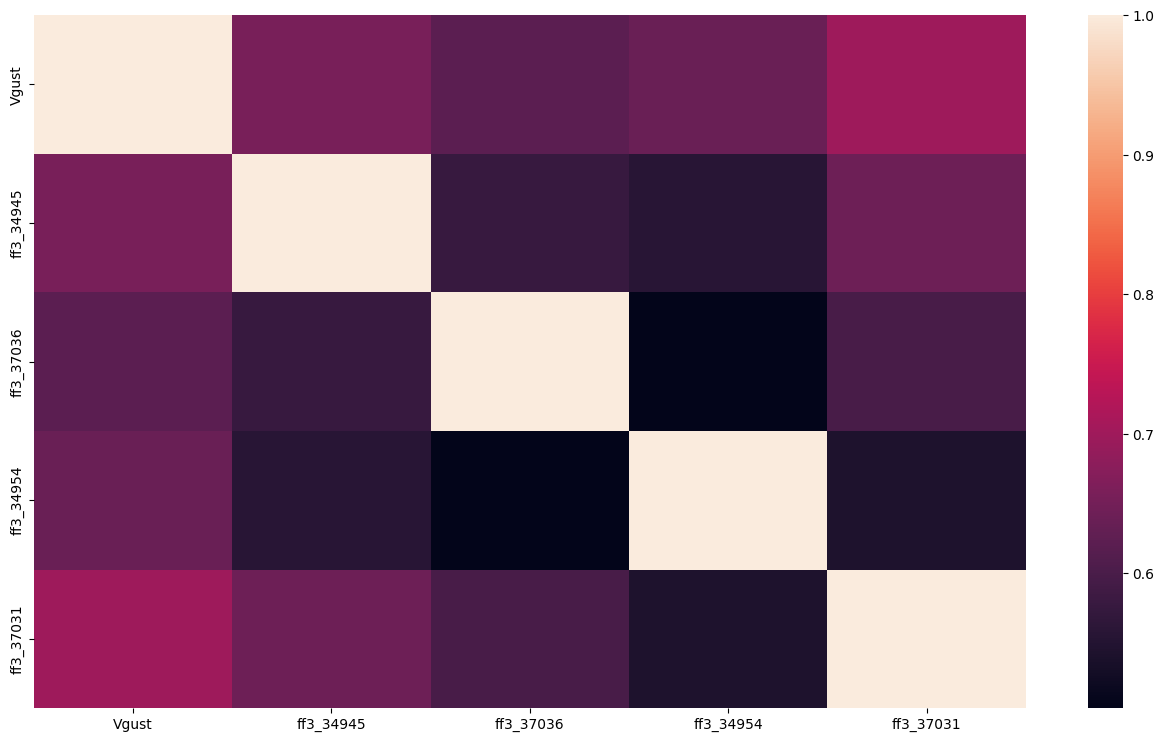

In [74]:
nameList=['Vgust']
for i in forecastList[1:]:
    nameList.append('ff3_'+str(i))
plt.figure(figsize=[16,9])
sns.heatmap(usefulDF[nameList].corr().abs())

In [75]:
# Переменная для обработки

Flag='Vgust'

# Можно взглянуть на данные по скорости порывов ветра по годам и суткам

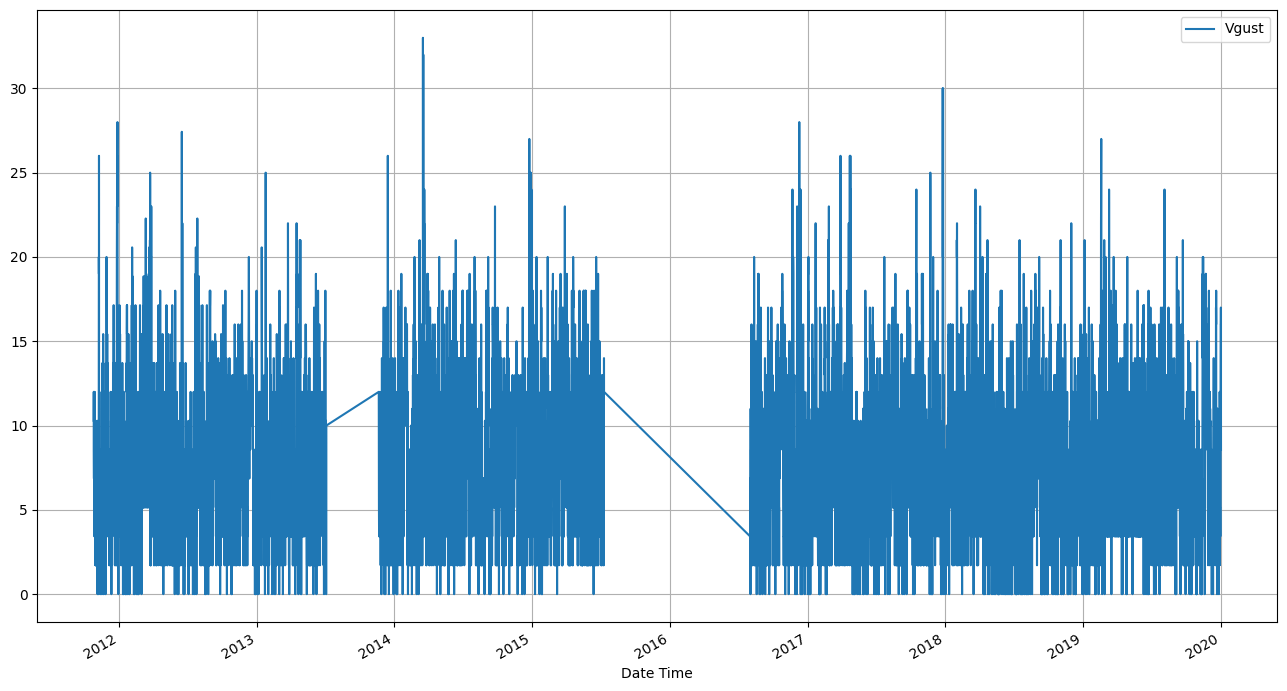

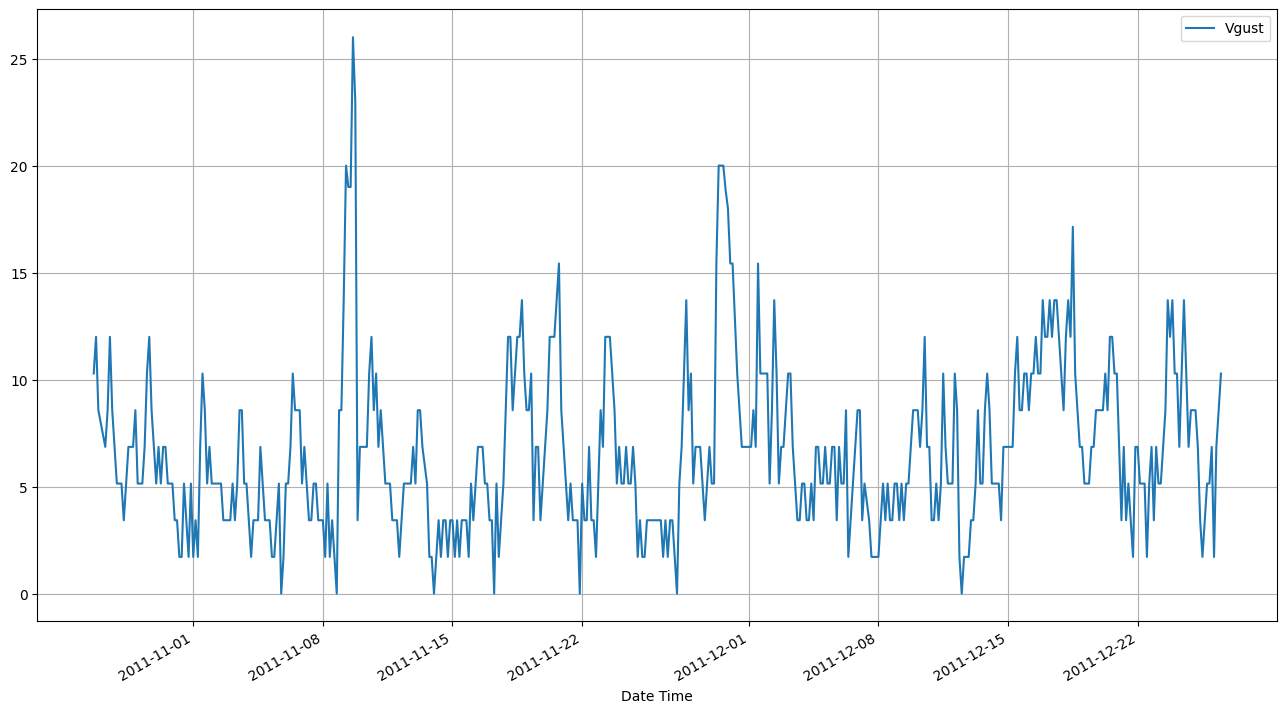

In [76]:
plot_cols = [Flag]
plot_features = usefulDF[plot_cols]

_ = plot_features.plot(subplots=True)

plot_features = usefulDF[plot_cols][:480]

_ = plot_features.plot(subplots=True)

# Статистика по всем данным

In [77]:
usefulDF.describe().transpose()

count      mean        std        min       25%           50%  \
T           19412.0  9.757207  10.768485 -27.400000  1.000000  9.200000e+00   
ff10_34949  19412.0  6.330192   3.758117   0.000000  4.285102  5.713470e+00   
Vgust       19412.0  7.698708   4.423527   0.000000  5.142123  6.856163e+00   
N_34949     19412.0  0.616555   0.383422   0.000000  0.250000  7.500000e-01   
Td_34949    19412.0  3.568190   7.668143 -30.200000 -1.600000  3.300000e+00   
...             ...       ...        ...        ...       ...           ...   
Wy_37031    19412.0 -0.521528   2.671027 -10.162675 -2.000000 -7.071068e-01   
Day sin     19412.0 -0.000178   0.706815  -1.000000 -0.707107  2.199795e-14   
Day cos     19412.0 -0.000758   0.707434  -1.000000 -0.707107 -3.969651e-14   
Year sin    19412.0  0.033998   0.700837  -1.000000 -0.656300  6.336051e-02   
Year cos    19412.0  0.047631   0.710953  -1.000000 -0.664768  9.330741e-02   

                  75%   max  
T           18.500000  36.4  
ff10_34949   8.570204  30.0  
Vgust       10.284245  33.0  
N_34949      1.000000   1.0  
Td_34949     9.800000  20.3  
...               ...   ...  
Wy_37031     0.707107  16.0  
Day sin      0.707107   1.0  
Day cos      0.707107   1.0  
Year sin     0.730810   1.0  
Year cos     0.762654   1.0  

[69 rows x 8 columns]

# Частотный анализ для значения скорости порывов ветра

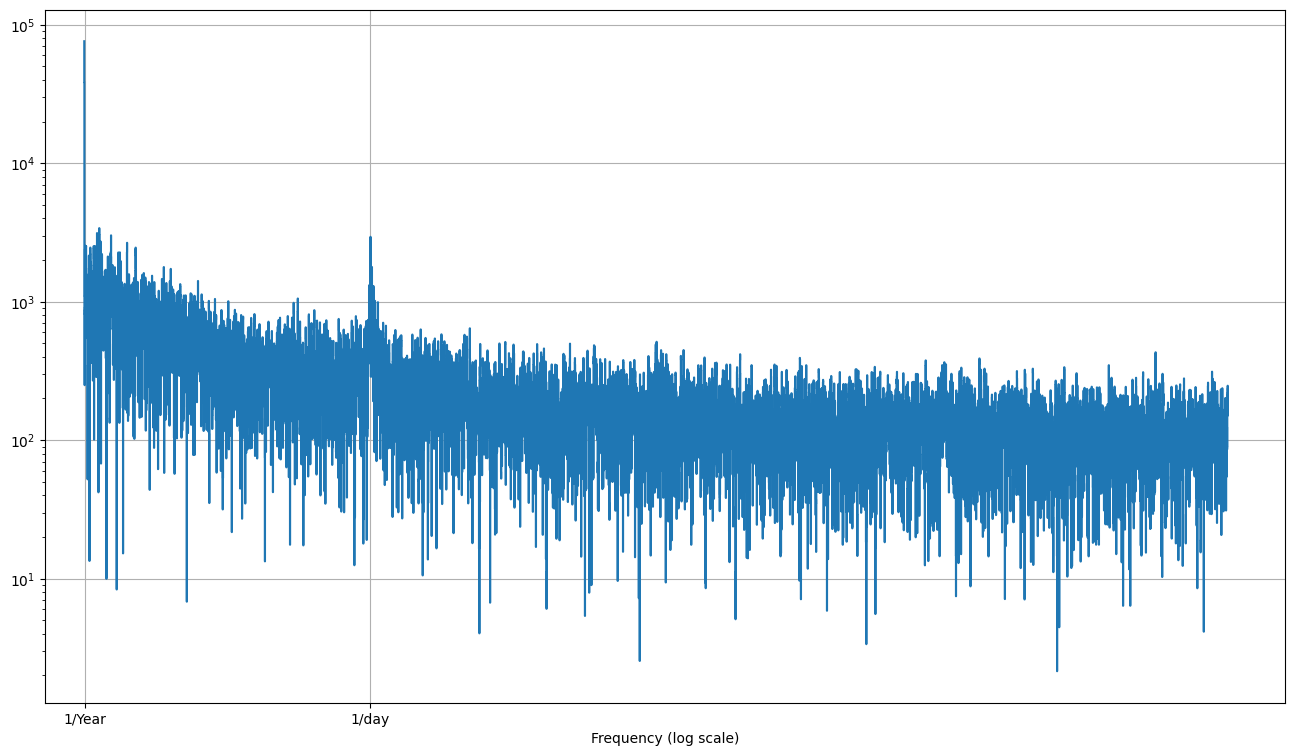

In [78]:
dataFFT=usefulDF[Flag]
dataFFT*=np.hanning(dataFFT.shape[0])
fft = tf.signal.rfft(dataFFT)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(usefulDF[Flag])
hours_per_year = 8*365
years_per_dataset = n_samples_h/(hours_per_year)


f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.yscale('log')

plt.xlim([-50, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


# Нормирование данных и подготовка датасетов

In [79]:
column_indices = {name: i for i, name in enumerate(usefulDF.columns)}

n = len(usefulDF)
train_df = usefulDF[0:int(n*0.7)]
val_df = usefulDF[int(n*0.7):int(n*0.9)]
test_df = usefulDF[int(n*0.9):]

num_features = usefulDF.shape[1]

In [80]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

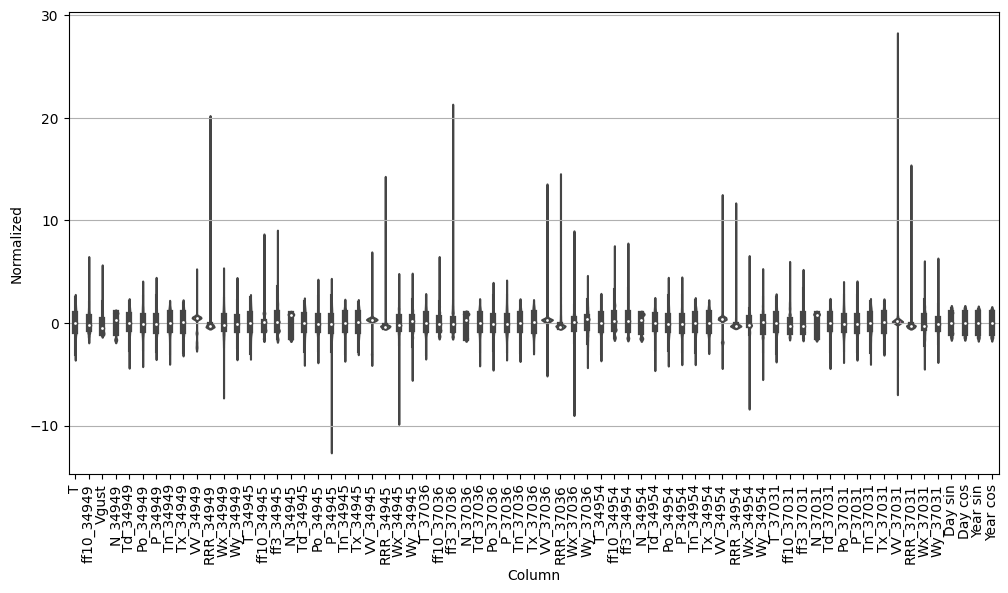

In [81]:
df_std = (usefulDF - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(usefulDF.keys(), rotation=90)

# Создание класса для генерации скользящего окна

In [82]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Сохраняем сырые данные.
        self.train_df = train_df.dropna()
        self.val_df = val_df.dropna()
        self.test_df = test_df.dropna()

        # Обработка индексов столбца меток.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Обработка параметров окна.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

# Создание двух вариантов окон w1, w2 для значения скорости порывов

In [83]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=[Flag])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Vgust']

In [84]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[Flag])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Vgust']

In [85]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Срезы не сохраняют статистические данные поэтому придется устанавливать размероности
    # вручную. Таким образом `tf.data.Datasets` легче проверить.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [86]:
# Если сложить три среза то получится длинна всего окна.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 69)
Inputs shape: (3, 6, 69)
labels shape: (3, 1, 1)


In [87]:
w2.example = example_inputs, example_labels

In [88]:
def plot(self, model=None, plot_col=Flag, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(16, 9))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices*3, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices*3, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices*3, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')
    #plt.xticks(np.arange(0, 1, step=0.2))

WindowGenerator.plot = plot

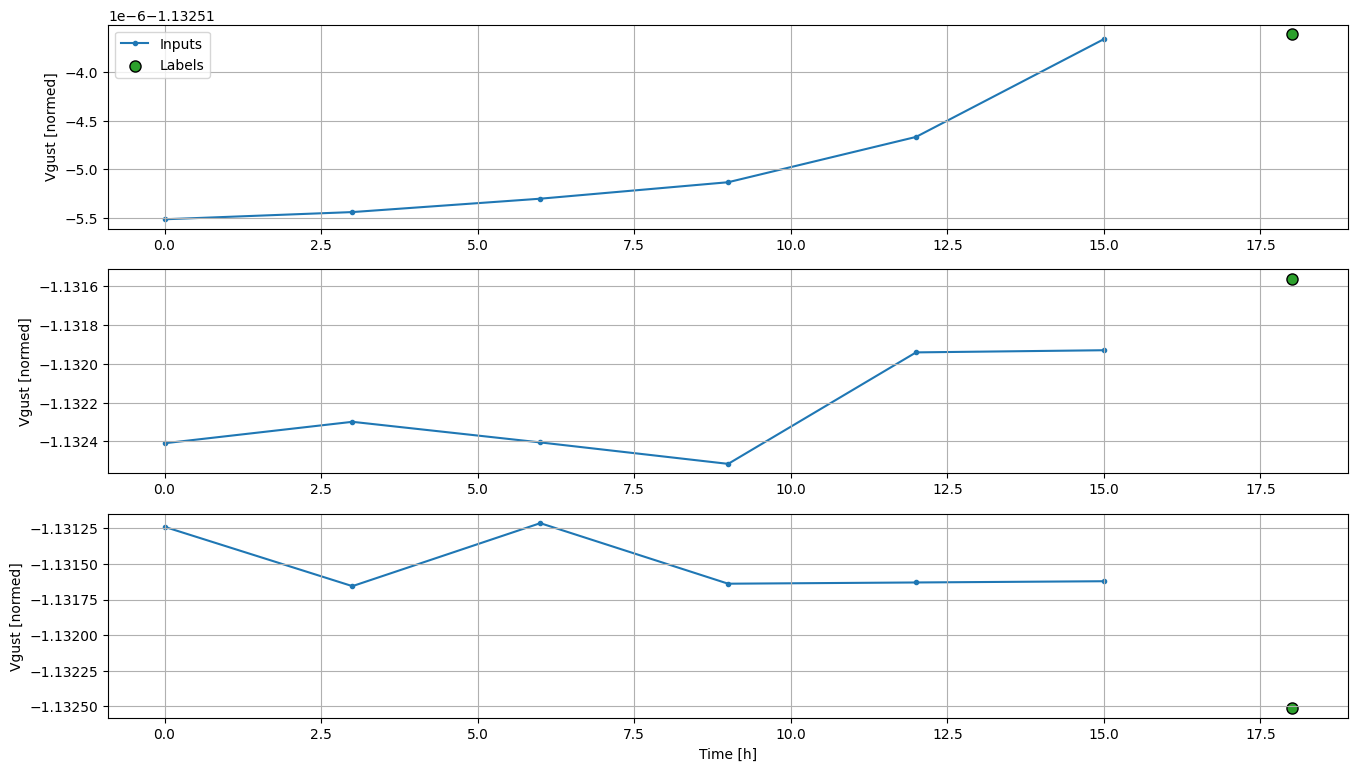

In [89]:
w2.plot()

## Модернизированная функция make_dataset, которая учитывает наличие разрывов в данных

In [90]:
def make_dataset_new(self, data):
    k = 0
    
    data = data.copy()
    
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
              data= np.array(data, dtype=np.float32),
              targets=None,
              sequence_length=self.total_window_size,
              sequence_stride=1,
              shuffle=True,
              batch_size=None,)
    
    while len(data)>0:
        if (data[Flag].first_valid_index() == data.isna()[Flag].idxmax()):
            partInd = data.index
            dspart =  data.loc[partInd]
            data.drop(partInd,inplace=True)
        else:
            partInd = data.loc[data[Flag].first_valid_index():data.isna()[Flag].idxmax()].iloc[:-1].index
            dspart =  data.loc[partInd]
            data.drop(partInd,inplace=True)
            nanInd = data.loc[data.isna()[Flag].idxmax():data[Flag].first_valid_index()].iloc[:-1].index

            data.drop(nanInd,inplace=True)  

            dspart = np.array(dspart, dtype=np.float32)

            ds_ = tf.keras.preprocessing.timeseries_dataset_from_array(
              data=dspart,
              targets=None,
              sequence_length=self.total_window_size,
              sequence_stride=1,
              shuffle=True,
              batch_size=None,)
            
            if (k == 0):
                ds = ds_
            else:
                ds = ds.concatenate(ds_)
            print(k)
            k = k + 1
        
    ds = ds.batch(32)
    print(ds)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset_new

### Для тестовой выборки оставляем make_dataset стандартную, в которой нет перемешивания данных - это нужно для удобства отрисовки

In [91]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_datasetTets = make_dataset

In [92]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_datasetTets(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [93]:
# Каждый элемент в паре (вход, метка)
w2.train.element_spec

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>


(TensorSpec(shape=(None, 6, 69), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [94]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
Inputs shape (batch, time, features): (32, 6, 69)
Labels shape (batch, time, features): (32, 1, 1)


In [95]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[Flag])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Vgust']

In [96]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
Inputs shape (batch, time, features): (32, 1, 69)
Labels shape (batch, time, features): (32, 1, 1)


# Класс для базовой модели

In [97]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [98]:
baseline = Baseline(label_index=column_indices[Flag])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
122/122 [==============================] - 0s 516us/step - loss: 0.0772 - mean_absolute_error: 0.1765


In [99]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[Flag])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Vgust']

In [100]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
Input shape: (32, 24, 69)
Output shape: (32, 24, 1)


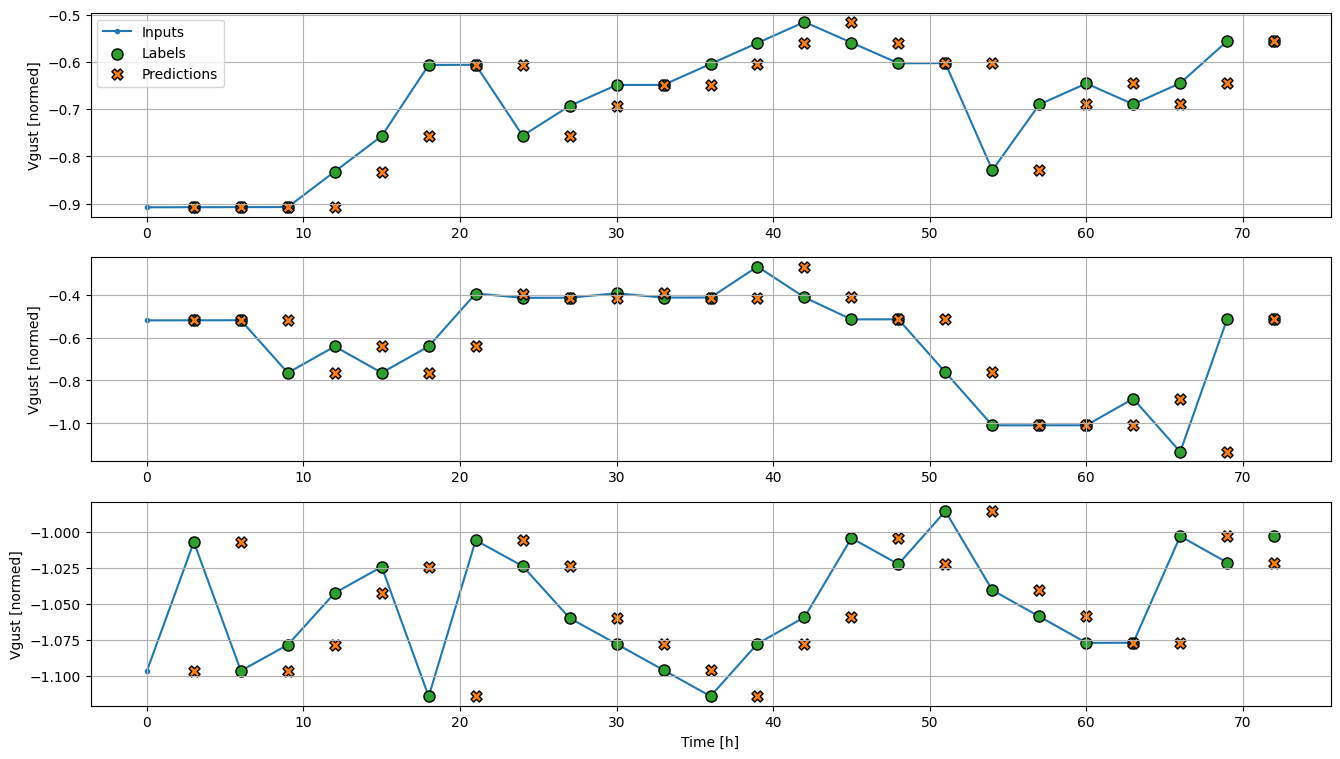

In [101]:
wide_window.plot(baseline)

# Линейная модель

In [102]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [103]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
Input shape: (32, 1, 69)
Output shape: (32, 1, 1)


In [104]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
  
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=opt,
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    log_dir = "logsVgust/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping, tensorboard_callback])
    return history

In [105]:
print(single_step_window.train)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
<MapDataset element_spec=(TensorSpec(shape=(None, 1, 69), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>


In [106]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
Epoch 1/200
425/425 [==============================] - 1s 1ms/step - loss: 0.3026 - mean_absolute_error: 0.3880 - val_loss: 0.0989 - val_mean_absolute_error: 0.2388
Epoch 2/200
425/425 [==============================] - 0s 825us/step - loss: 0.2204 - mean_absolute_error: 0.3353 - val_loss: 0.1076 - val_mean_absolute_error: 0.2524
Epoch 3/200
425/425 [==============================] - 0s 801us/step - loss: 0.2165 - mean_absolute_error: 0.3296 - val_loss: 0.0923 - val_mean_absolute_error: 0.2326
Epoch 4/200
425/425 [==============================] - 0s 791us/step - loss: 0.2198 - mean_absolute_error: 0.3350 - val_loss: 0.0844 - val_mean_absolute_error: 0.2171
Epoch 5/200
425/425 [==============================] - 0s 778us/step - loss: 0.2200 - mean_absolute_error: 0.3333 - val_loss: 0.0980 - val_mean_absolu

In [107]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 69)
Output shape: (32, 24, 1)


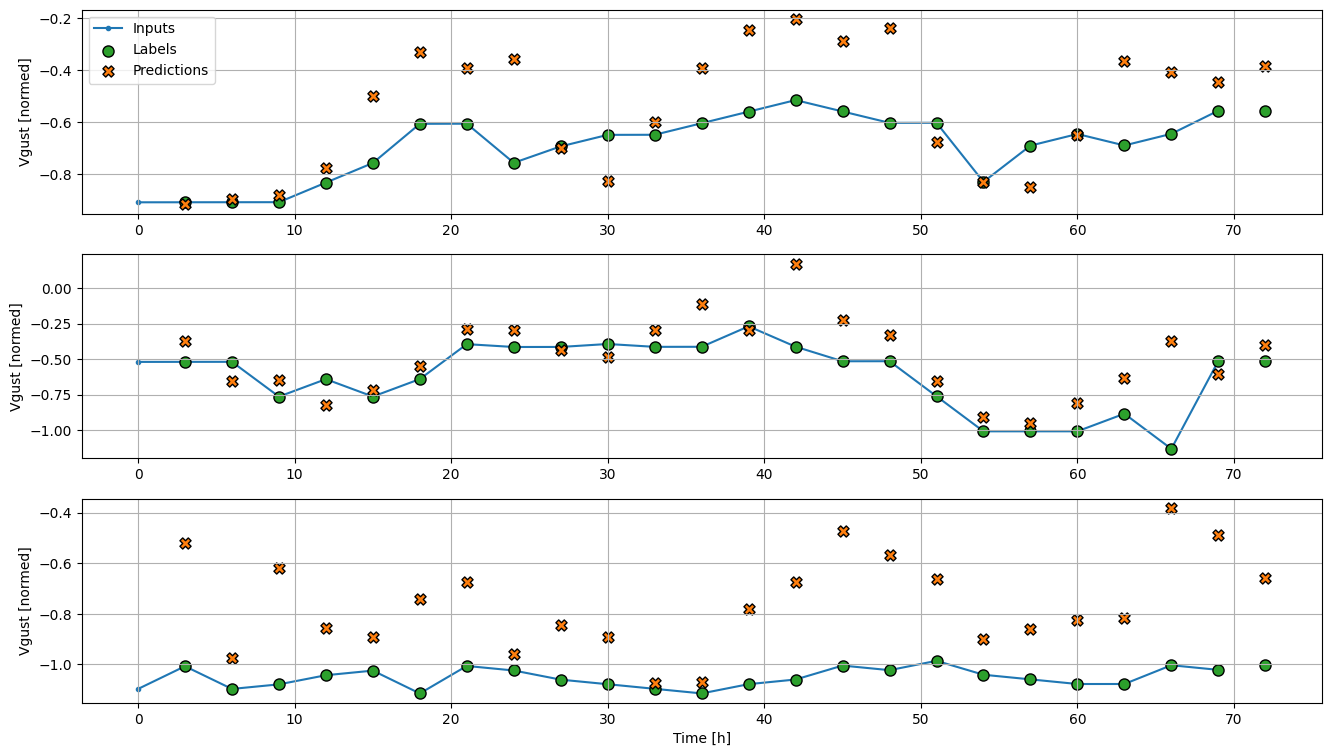

In [108]:
wide_window.plot(linear)

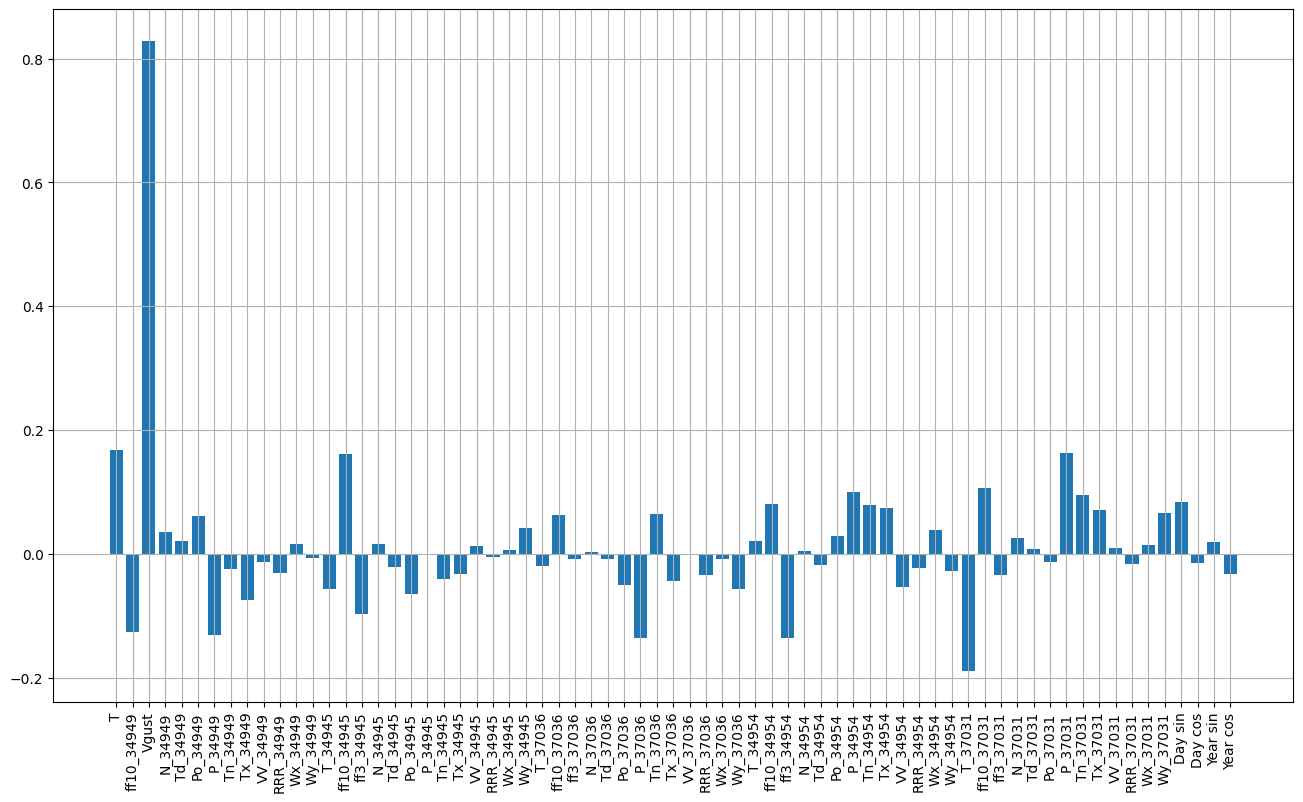

In [109]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Полносвязная нейронная сеть
Прежде чем применять модели, которые фактически работают с несколькими временными шагами, стоит проверить производительность более мощных моделей с одним входом.

Эта модель похожа на линейную, за исключением того что она складывает несколько последовательных полносвязных нейронных слоев между входом в модель и выходом из нее.

In [110]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
Epoch 1/200
425/425 [==============================] - 1s 1ms/step - loss: 0.2477 - mean_absolute_error: 0.3618 - val_loss: 0.1016 - val_mean_absolute_error: 0.2421
Epoch 2/200
425/425 [==============================] - 0s 1ms/step - loss: 0.1820 - mean_absolute_error: 0.3046 - val_loss: 0.0785 - val_mean_absolute_error: 0.2135
Epoch 3/200
425/425 [==============================] - 0s 1ms/step - loss: 0.1739 - mean_absolute_error: 0.2973 - val_loss: 0.1159 - val_mean_absolute_error: 0.2738
Epoch 4/200
425/425 [==============================] - 0s 1ms/step - loss: 0.1706 - mean_absolute_error: 0.2937 - val_loss: 0.0881 - val_mean_absolute_error: 0.2233
Epoch 5/200
425/425 [==============================] - 0s 1ms/step - loss: 0.1645 - mean_absolute_error: 0.2863 - val_loss: 0.0667 - val_mean_absolute_error

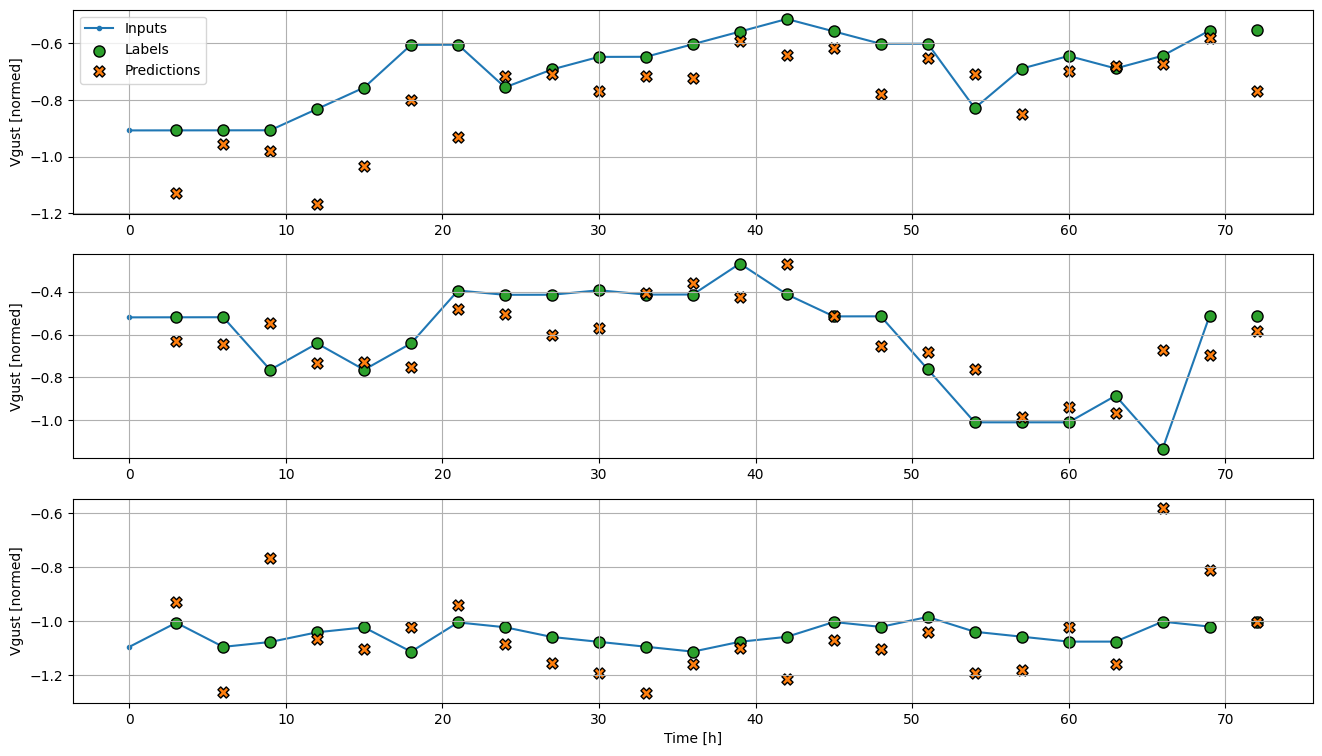

In [111]:
wide_window.plot(dense)

### SHAP (график строится корректно только для OS Linux)

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

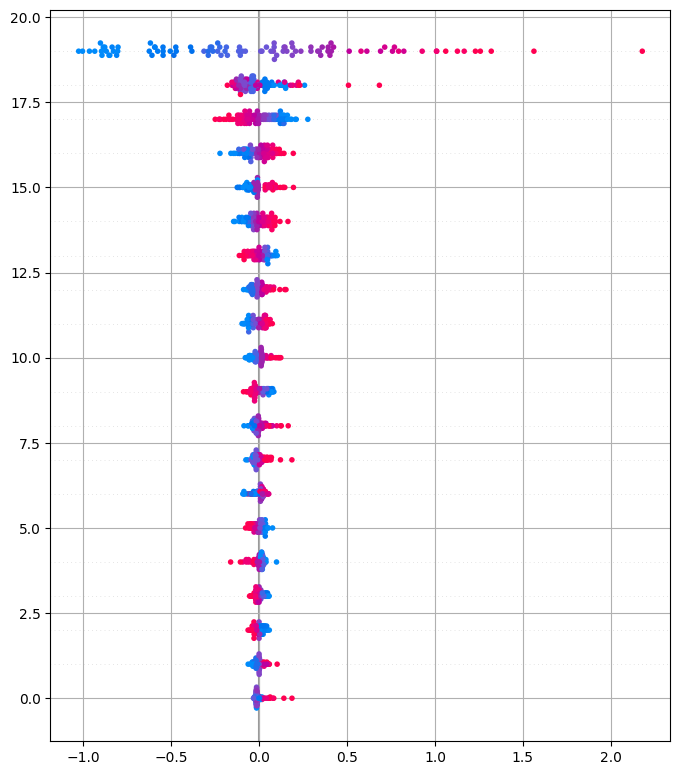

In [112]:
warnings.filterwarnings('ignore')
shap.initjs()

x_train=wide_window.train_df
background = x_train.sample(100) # SHAP отображает выборку из данных. Строить все было бы слишком долго.
explainer = shap.KernelExplainer(dense,background)# x_train.iloc[:1000,:])
X_sampled=background#x_train.iloc[:100,:]
shap_values = explainer.shap_values(X_sampled)
# shap.force_plot(explainer.expected_value, shap_values[0], X_sampled,matplotlib=True)
# plt.show()
# shap.plots._waterfall.waterfall_legacy(shap_values[0], max_display=10)
shap.summary_plot(
    (shap_values)[0],X_sampled)

### Многошаговая полносвязная нейронная сеть

Одношаговая модель находится вне контекста, попробуем дать ей доступ к предыдущим временным шагам


A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](pics/conv_window.png)


`baseline`, `linear` и `dense` обрабатывают каждый временной шаг независимо. Теперь настало время подавать на вход модели несколько временных шагов и на остовании их делать предстказания.

Созданим `WindowGenerator` который производит пакеты из трехчасового входа и одначасовой метки:

Обратите внимание что параметр `shift` у `Window`  относится к концу двух окон.


In [113]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[Flag])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Vgust']

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>


Text(0.5, 1.0, 'Given 6h as input, predict 3h into the future.')

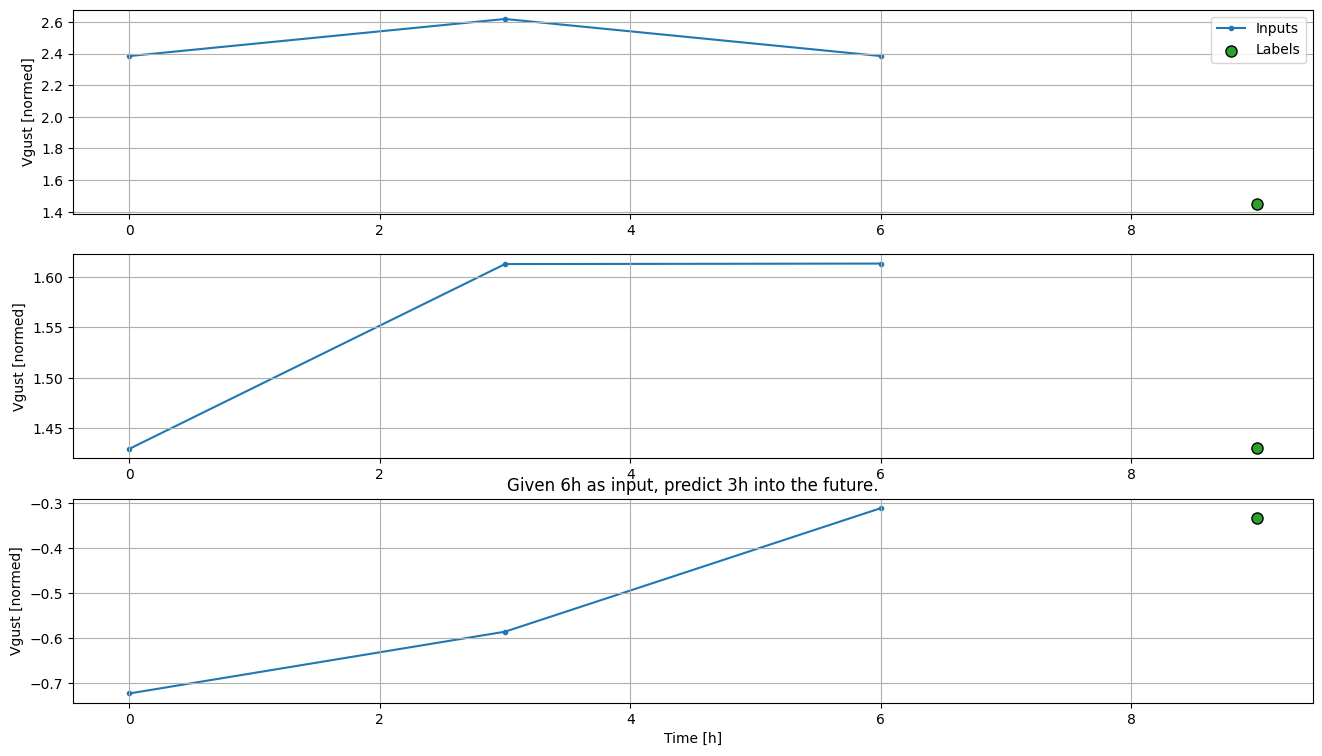

In [114]:
conv_window.plot()
plt.title("Given 6h as input, predict 3h into the future.")

Можно обучить модель `dense` добавлением слоя `layers.Flatten` как первого слоя у модели:

In [115]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [116]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 69)
Output shape: (32, 1, 1)


In [117]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
122/122 [==============================] - 0s 516us/step - loss: 0.0750 - mean_absolute_error: 0.1981


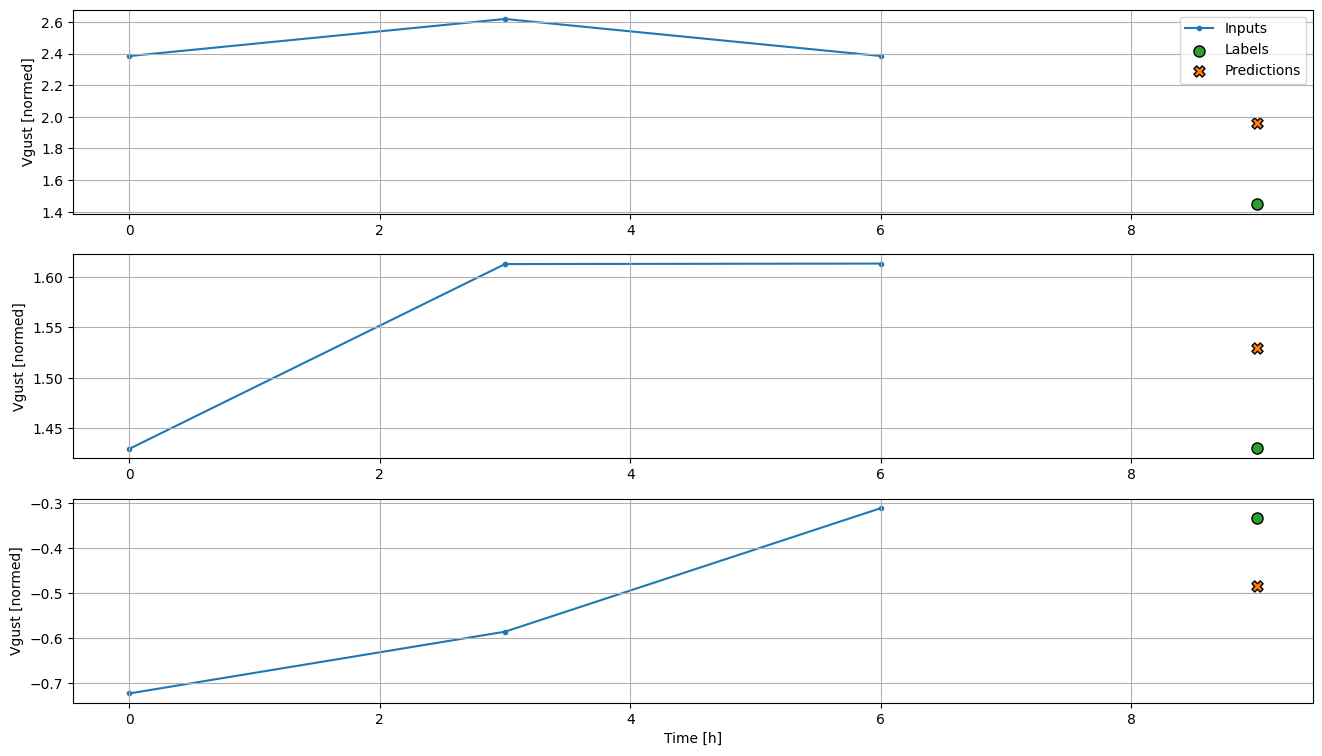

In [118]:
conv_window.plot(multi_step_dense)

Основным недостатком этого подхода является то, что результирующая модель может быть реализована только в окнах такой размерности.

In [119]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 69)

ValueError:Exception encountered when calling layer "sequential_3" "                 f"(type Sequential).

Input 0 of layer "dense_7" is incompatible with the layer: expected axis -1 of input shape to have value 207, but received input with shape (32, 1656)

Call arguments received by layer "sequential_3" "                 f"(type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 69), dtype=float32)
  • training=None
  • mask=None


Сверточная модель позволяет избавиться от этой проблемы.
### Сверточная нейронная сеть
 
Сверточный слой (`layers.Conv1D`)  также может принимать несколько временных шагов на вход для каждого предсказания.

Ниже **та же самая** модель что и `multi_step_dense`, но со сверткой.

Изменения:
* `layers.Flatten` и первый полносвязный слой заменены на `layers.Conv1D`.
* `layers.Reshape` больше не нужен так как свертка сохраняет ту же размерность на выходе.

In [120]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

В этом можно убедиться запустив его для пакета:

In [121]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 69)
Output shape: (32, 1, 1)


Обучим и оценим  `conv_window` она должна дать ту же производительность что и `multi_step_dense`.

In [122]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
122/122 [==============================] - 0s 516us/step - loss: 0.0833 - mean_absolute_error: 0.2258


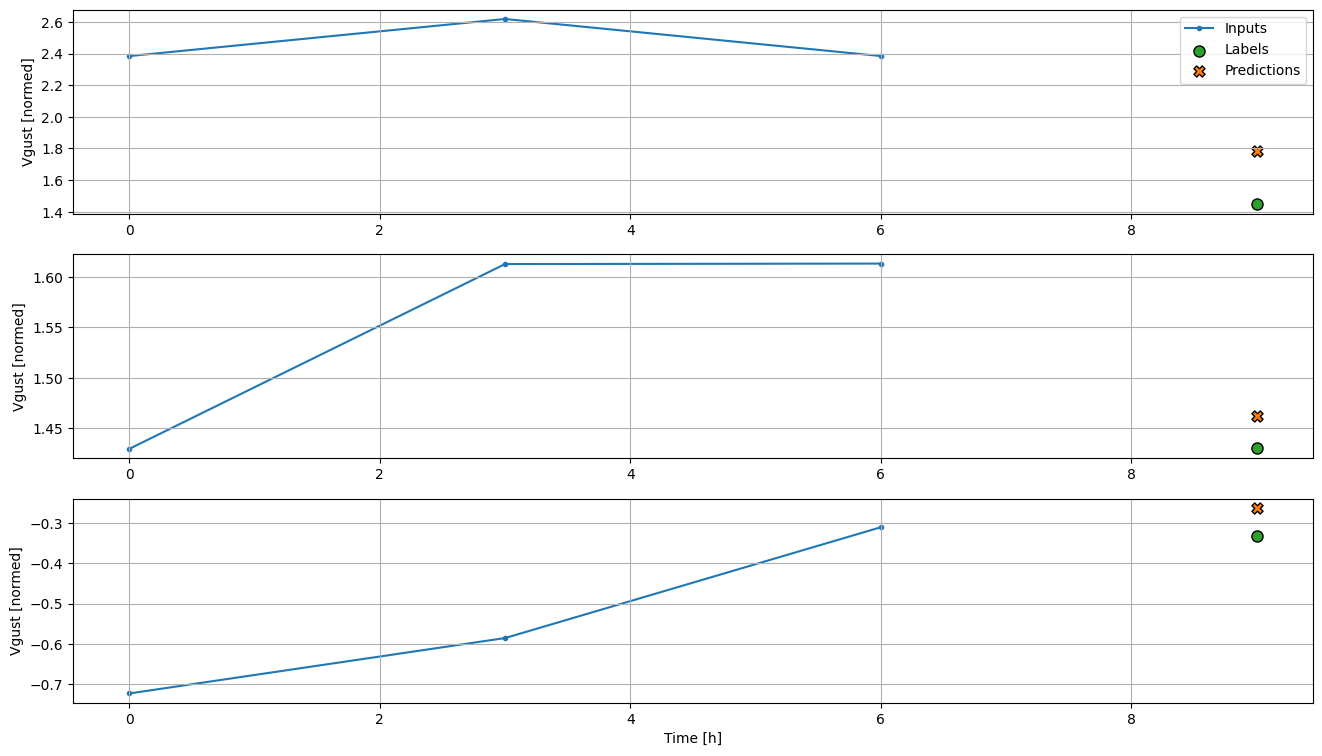

In [123]:
conv_window.plot(conv_model)

Разница между `conv_model` и `multi_step_dense` в том что `conv_model` может быть запущена для входя любого размера. Сверточный слой применяется к скользящему окну входов:

![Executing a convolutional model on a sequence](pics/wide_conv_window.png)

Если расширить вход, это расширит выход:

In [124]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 69)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [125]:
# Видно что выход короче чем вход. Чтобы процедура обучения и визуализации работала корректно нам нужно чтобы и метки были той же длинны. Нужно построить `WindowGenerator` для производства расширенных окон с несколькими дополнительными входами: 

In [126]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[Flag])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Vgust']

In [127]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
Input shape: (32, 26, 69)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Теперь мы можем строить предсказания на расширенных окнах. Заметим что 3 преде первым предсказанием мы имеем 3 входных шага. Каждое предсказание базируется на трех предыдузщих шагах по времени.

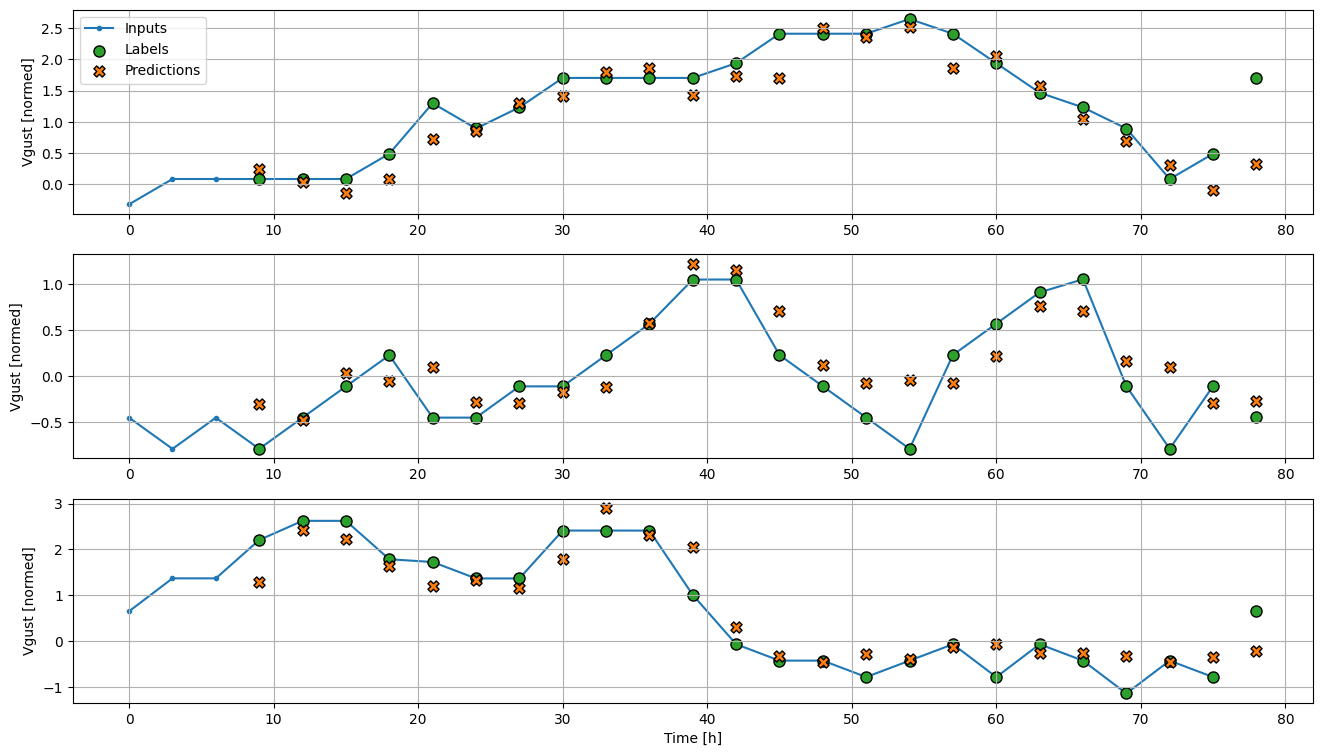

In [128]:
wide_conv_window.plot(conv_model)

### Рекуррентная нейронная сеть

Рекуррентная нейронная сеть (RNN) это тип нейронной сети который хорошо подходит для временных рядов. RNN обрабатывает временой ряд шаг за шагом и сохраняет внутри себя каждую стадию.

Более прдробно можно ознакомиться [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) или [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

В этом руководстве используются RNN слои называемые слои Долгосрочной Кратковременной Памяти ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

Важной конструкционной особеннойстью всех RNN слоев в keras это аргумент  `return_sequences`. Он задается одним из двух способов.

1. Если `False`, по-умолчанию, слой возвращает только выход конечного временного шага, используя все загруженное в модель время для создания единого прогноза:

![An lstm warming up and making a single prediction](pics/lstm_1_window.png)

2. Если `True` то слой возвращает выход для каждого входа. Это полезно:
  * Для последовательного соединения RNN слоев. 
  * Обучения модели на множестве временных шагов одновременно.

![An lstm making a prediction after every timestep](pics/lstm_many_window.png)

In [129]:
wide_window.__dict__.keys()

dict_keys(['train_df', 'val_df', 'test_df', 'label_columns', 'label_columns_indices', 'column_indices', 'input_width', 'label_width', 'shift', 'total_window_size', 'input_slice', 'input_indices', 'label_start', 'labels_slice', 'label_indices', '_example'])

In [130]:
lstm_model = tf.keras.models.Sequential([
    # Размерность [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Размерность => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])




#tf.keras.models.Sequential([tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=[len(wide_window.__dict__.keys())]),\
#     tf.keras.layers.Dense(16, activation=tf.nn.relu),\
#     tf.keras.layers.Dense(1)])

С `return_sequences=True` Модель может быть обучена на 24х часах за раз

Замечание: Это скажется на оценке производительности так как она не сможет поначалу давать предсказания.

In [131]:
#history = compile_and_fit(conv_model, wide_window)
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
121/121 [==============================] - 0s 2ms/step - loss: 0.1019 - mean_absolute_error: 0.2351


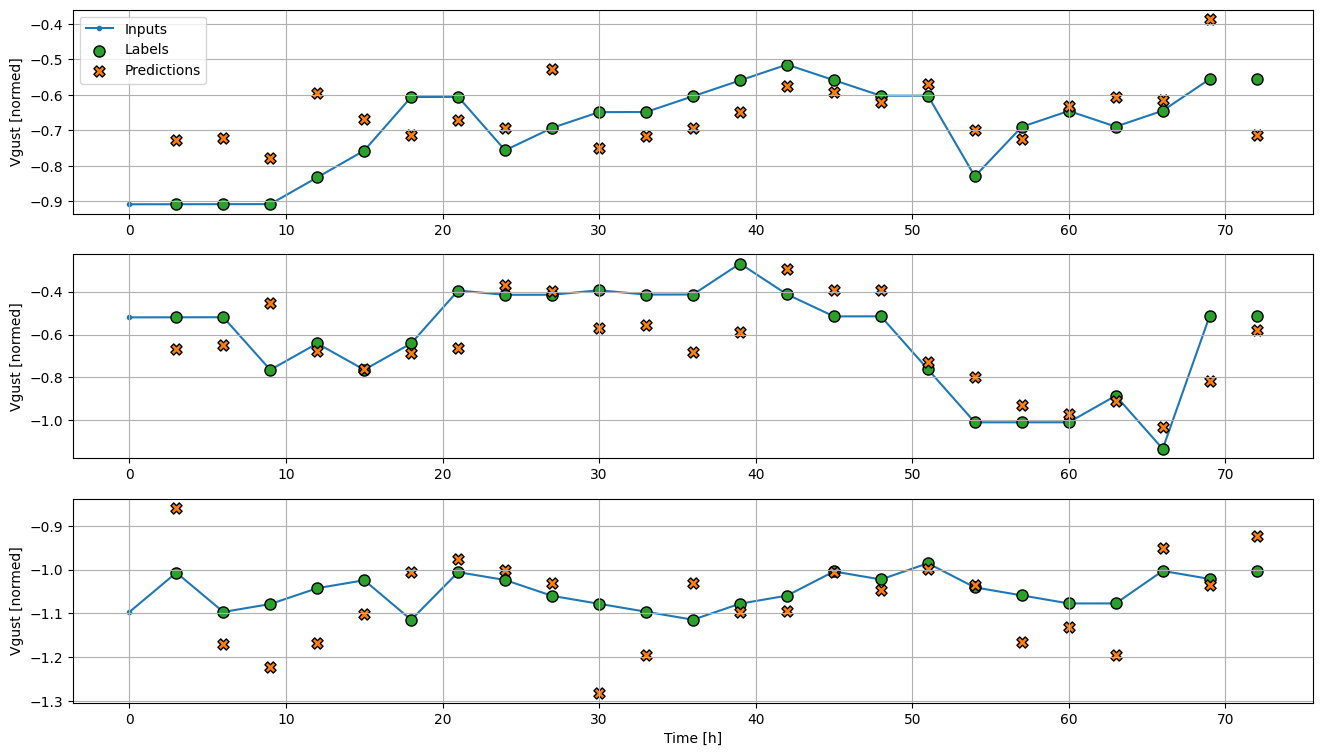

In [132]:
wide_window.plot(lstm_model)

### Производительность
С таким набором данных модель работает немного лучше.

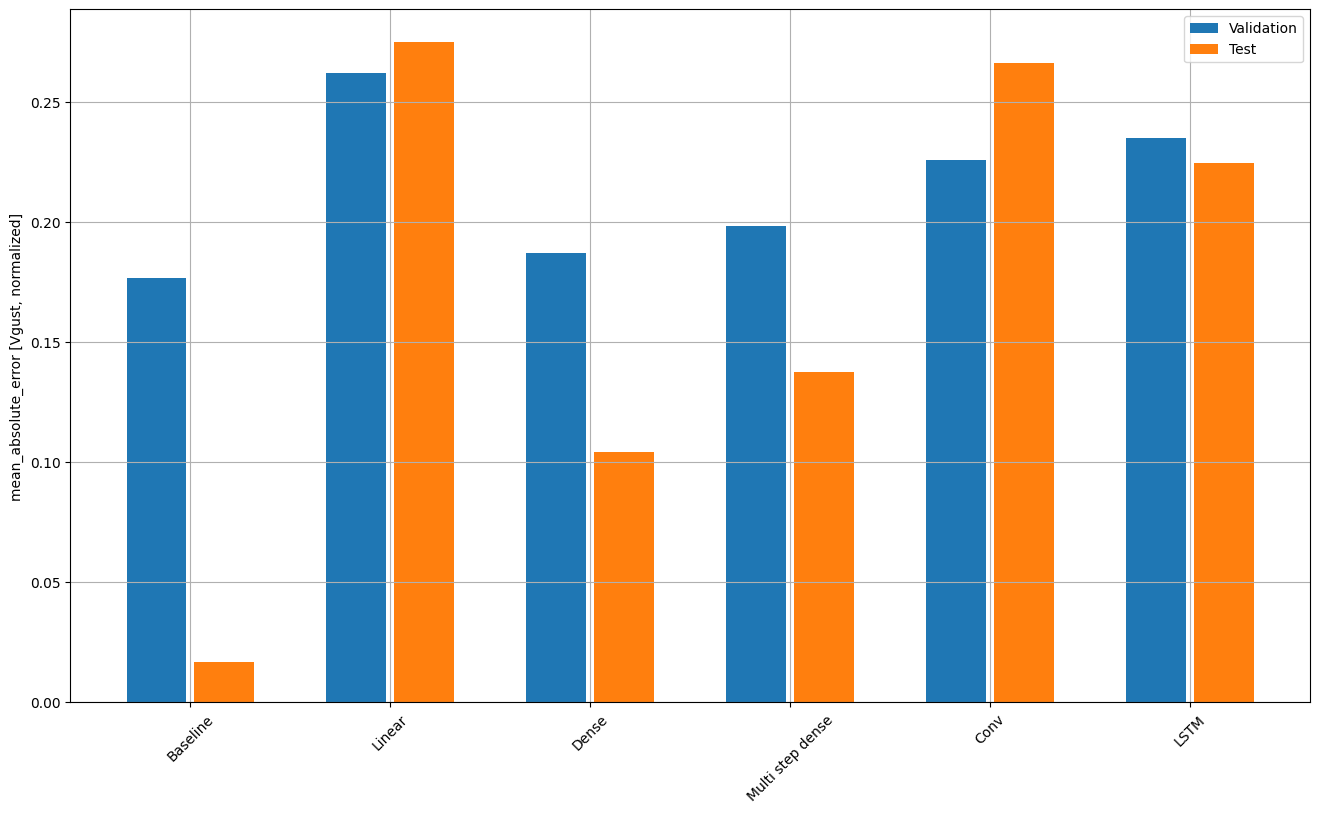

In [133]:
plt.figure(figsize=(16,9))

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Vgust, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [134]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0167
Linear      : 0.2747
Dense       : 0.1041
Multi step dense: 0.1373
Conv        : 0.2663
LSTM        : 0.2246


In [135]:
single_step_window = WindowGenerator(#WindowGenerator
    # `WindowGenerator` возвращает все признаки если вы не поставить
    #  `label_columns`.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
Inputs shape (batch, time, features): (32, 24, 69)
Labels shape (batch, time, features): (32, 24, 69)


### Модель со множеством выходов

Модели до этого предсказывали только скорость порывов на каждом временном шаге.

Все этим модели могут предсказывать не только ее, нужно всего-лишь изменить количество выходов и скорректировать окно обучения чтобы включить все признаки в метки.

Теперь размерность туже глубино что и вход, вместо 1.

#### Базовая модель

Может быть использована та же самая базовая модель, но теперь необходимо повторить это для всех признаков вместо выбора `label_index`.

In [136]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [137]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
121/121 [==============================] - 0s 579us/step - loss: 0.3004 - mean_absolute_error: 0.2650


In [138]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [139]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
122/122 [==============================] - 0s 516us/step - loss: 0.2309 - mean_absolute_error: 0.3005


#### RNN


In [140]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Размерность [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Размерность => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
121/121 [==============================] - 0s 2ms/step - loss: 0.2003 - mean_absolute_error: 0.2624

CPU times: total: 2min 40s
Wall time: 48.5 s


<a id="residual"></a>

#### Дополнительно: Остаточные соединения

Приемущества базовой модели состоит в том что она не меняется при новом запуске. Каждая модель обученная в этом руководстве имеет случайно инициализированные веса и результаты могут отличаться.

Эту проблему можно обойти если задать иной способ инициализации весов .

Часто в анализе временных рядов предсказывают не значение на следующем временном шаге, а то как сильно изменится предсказываемая величина. По аналогии с остаточными сетями или "ResNets" в глубоком обучении архитектуры которых на каждом слое добавляют к результату. 


Это позволяет использовать интуитивное сообржение о том, что изменение должно быть небольшим.

![A model with a residual connection](pics/residual.png)

По сути, это инициализирует модель в соответствии с базовой моделью. Для этой задачи он помогает моделям быстрее сходиться с немного лучшей производительностью.

Этот подход можно использовать в сочетании с любой моделью, обсуждаемой в этом руководстве.

Здесь он применяется к модели LSTM, обратите внимание на использование `tf.initializers.zeros`, чтобы гарантировать, что начальные предсказанные изменения невелики и не перекрывают остаточное соединение. Здесь нет проблем с нарушением гладкости для градиентов, поскольку "нули" используются только на последнем слое.

In [141]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [142]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
121/121 [==============================] - 0s 2ms/step - loss: 0.2016 - mean_absolute_error: 0.2443

CPU times: total: 2min 7s
Wall time: 38.5 s


#### Производительность

Вот общая производительность для этих моделей с несколькими выходами.

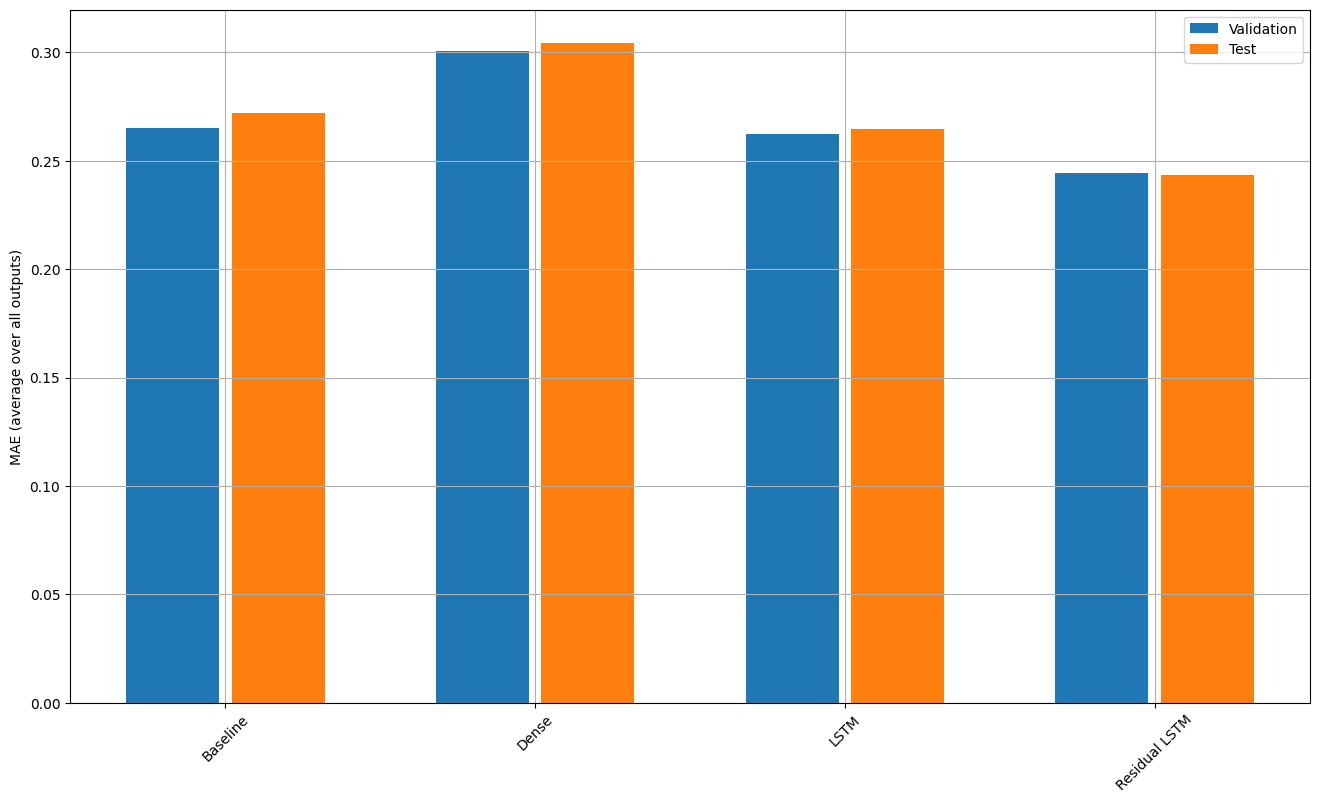

In [143]:
plt.figure(figsize=(16,9))
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [144]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.2721
Dense          : 0.3045
LSTM           : 0.2645
Residual LSTM  : 0.2434


Вышеуказанные характеристики усреднены по всем выходным данным модели.

In [145]:
%tensorboard --logdir logsVgust/fit

## Многошаговые модели

И модели с одним выходом, и с несколькими выходами в предыдущих разделах делали **прогнозы с одним временным шагом** на 1 час вперед.

В этом разделе рассматривается, как расширить эти модели, чтобы сделать **прогнозы с несколькими временными шагами**.

При многоэтапном прогнозировании модели необходимо научиться прогнозировать диапазон будущих значений. Таким образом, в отличие от одношаговой модели, в которой прогнозируется только одна будущая точка, многоступенчатая модель прогнозирует последовательность будущих значений.

Есть два грубых подхода:

1. Прогнозы, при которых прогнозируется сразу весь временной ряд.
2. Авторегрессионные прогнозы, когда модель делает только одношаговые прогнозы, а ее выходные данные возвращаются в качестве входных данных.

В этом разделе все модели будут предсказывать **все функции на всех временных шагах вывода**.

Для многошаговой модели обучающая выборка снова состоят из почасовых срезов. Однако здесь модели научатся предсказывать 24 часа будущего, учитывая 24 часа прошлого. 
`Window` генерирует эти срезы из набора данных::



<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

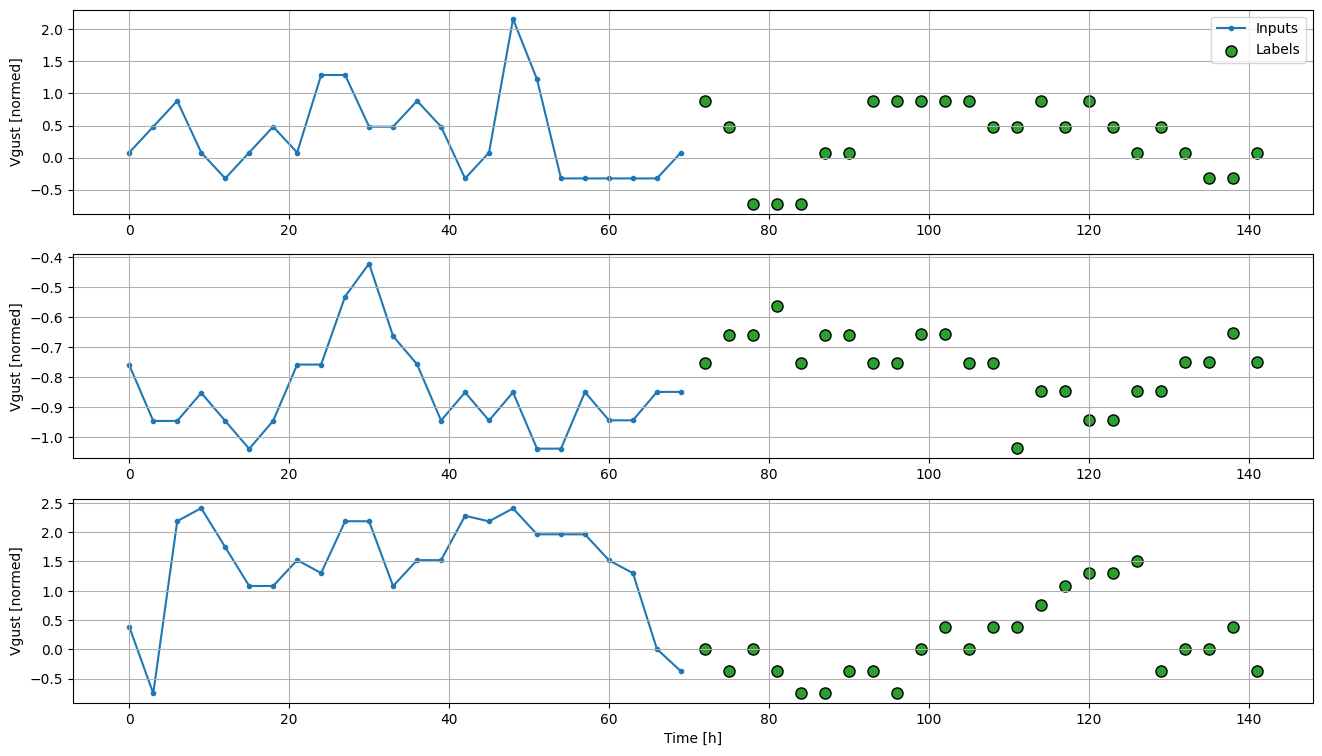

In [146]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Базовая модель

Простая базовая модель - повторить последний временной шаг ввода для необходимого количества временных шагов ввода:

![Repeat the last input, for each output step](pics/multistep_last.png)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
120/120 [==============================] - 0s 754us/step - loss: 0.9253 - mean_absolute_error: 0.5946


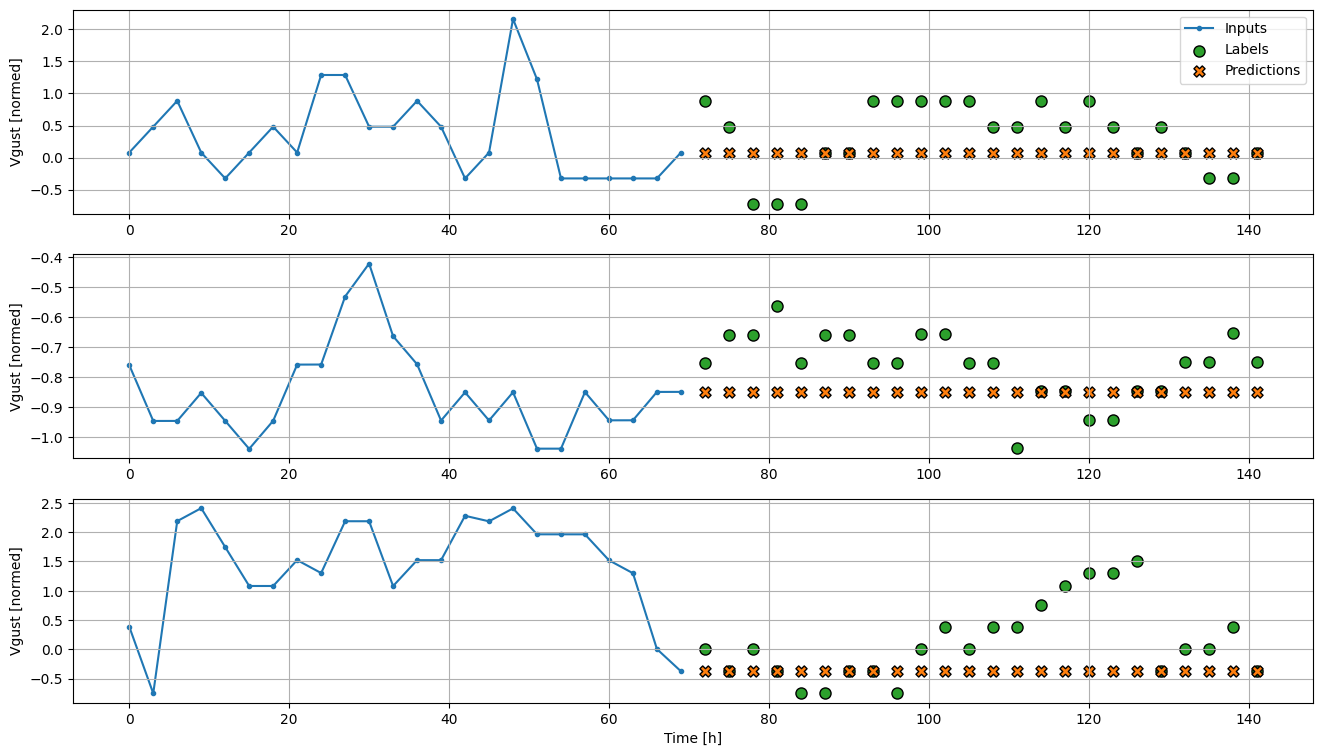

In [147]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Поскольку эта задача - предсказать 24 часа с учетом 24 часов, другой простой подход - повторить предыдущий день, предполагая, что завтра будет аналогичным:

![Repeat the previous day](pics/multistep_repeat.png)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
120/120 [==============================] - 0s 738us/step - loss: 1.0163 - mean_absolute_error: 0.6403


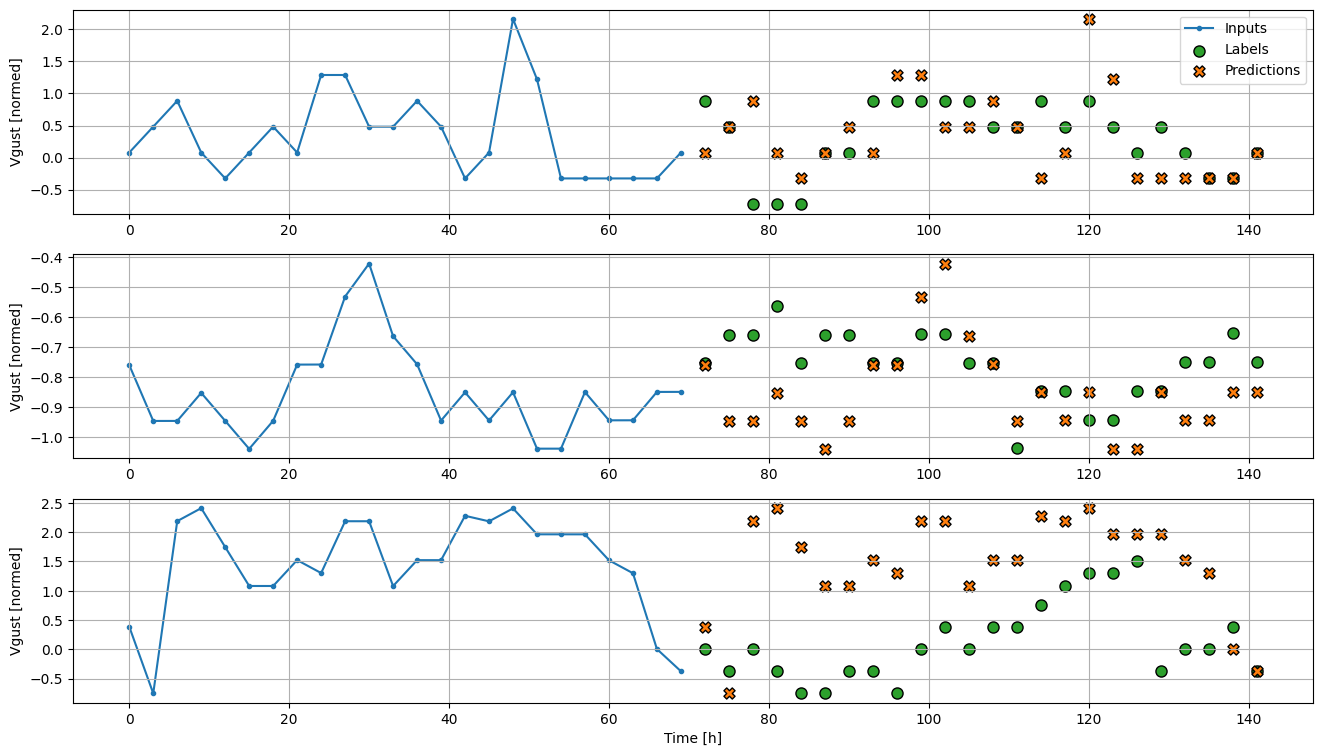

In [148]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Одношаговые модели

Один из высокоуровневых подходов к этой проблеме - использование «одношаговой» модели, в которой модель выполняет прогнозирование всей последовательности за один шаг.

Это может быть релизовано с помощью `layers.Dense` и `OUT_STEPS*features` на выходе. Модель просто должна изменить форму этого вывода на требуемый `(OUTPUT_STEPS, features)`.

#### Линейная модель

Простая линейная модель, основанная на последнем временном шаге ввода, работает лучше, чем любая базовая, но имеет недостаточную мощность. Модель должна предсказывать временные шаги OUTPUT_STEPS из одного временного шага ввода с линейной проекцией. Он может фиксировать только малоразмерный срез, вероятно, основанный в основном на времени суток и времени года. 

![Predct all timesteps from the last time-step](pics/multistep_dense.png)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
120/120 [==============================] - 0s 955us/step - loss: 0.5088 - mean_absolute_error: 0.4884


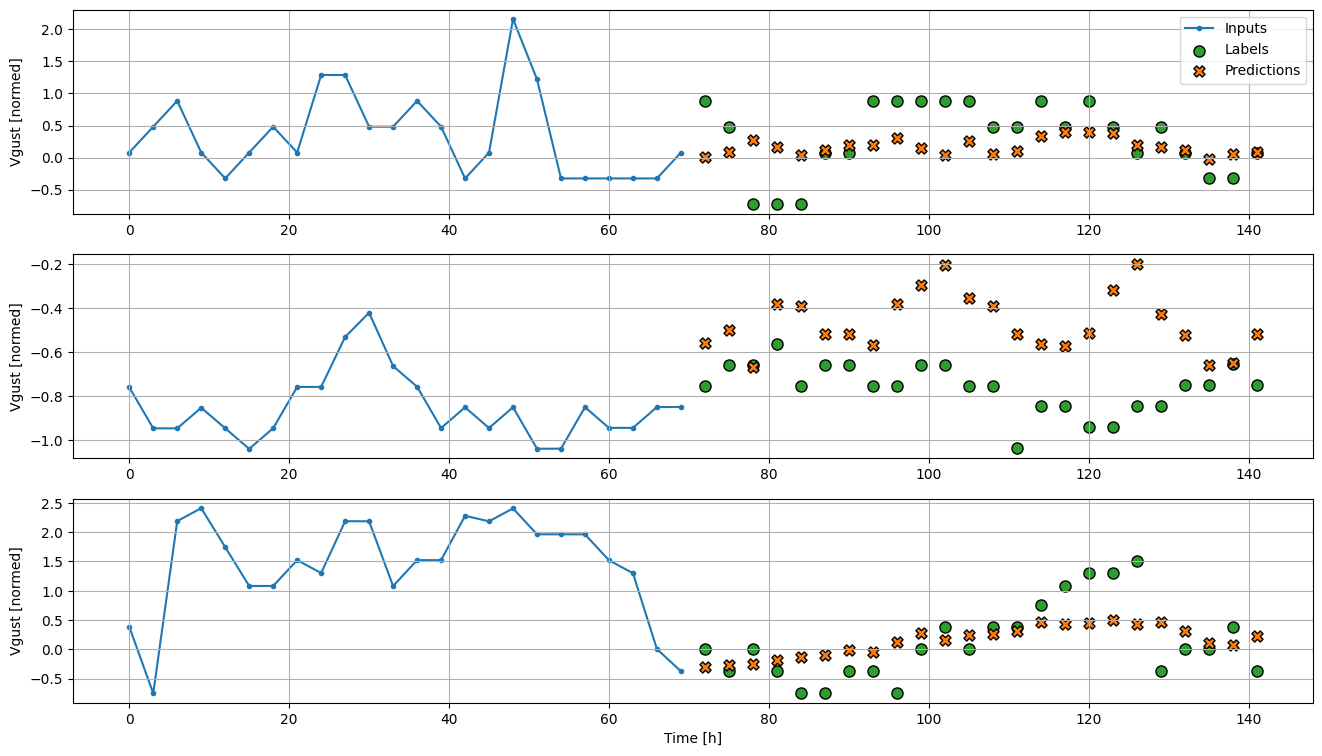

In [149]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Полносвязная нейронная сеть

Добавление `layers.Dense` между входом и выходом даст линейной модели больше предсказательной силы, Но она по прежнему будет опираться на один входной шаг по времени.

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
120/120 [==============================] - 0s 3ms/step - loss: 0.5141 - mean_absolute_error: 0.4951


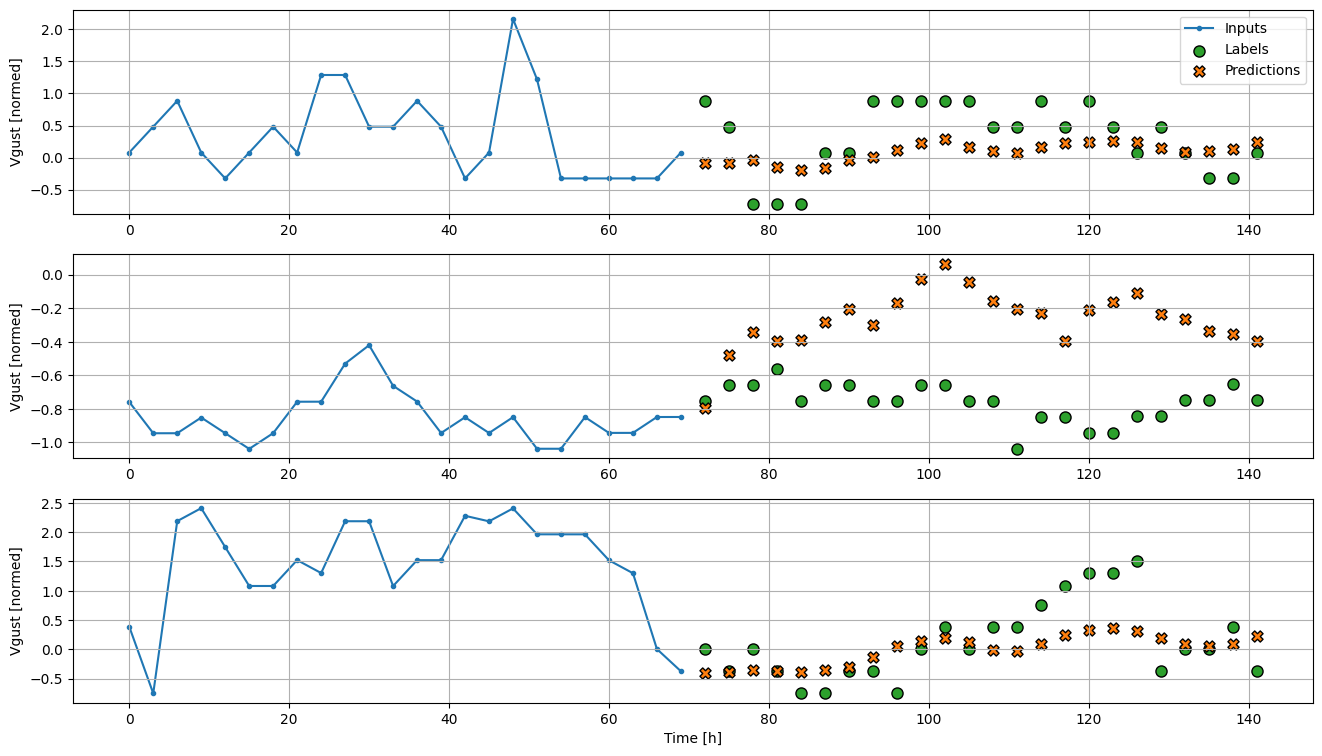

In [150]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

Сверточная модель делает прогнозы на основе истории фиксированной ширины, что может привести к более высокой производительности, чем полносвязная модель, поскольку она может видеть, как ряд мняется с течением времени:

![A convolutional model sees how things change over time](pics/multistep_conv.png)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
120/120 [==============================] - 0s 2ms/step - loss: 0.5249 - mean_absolute_error: 0.5064


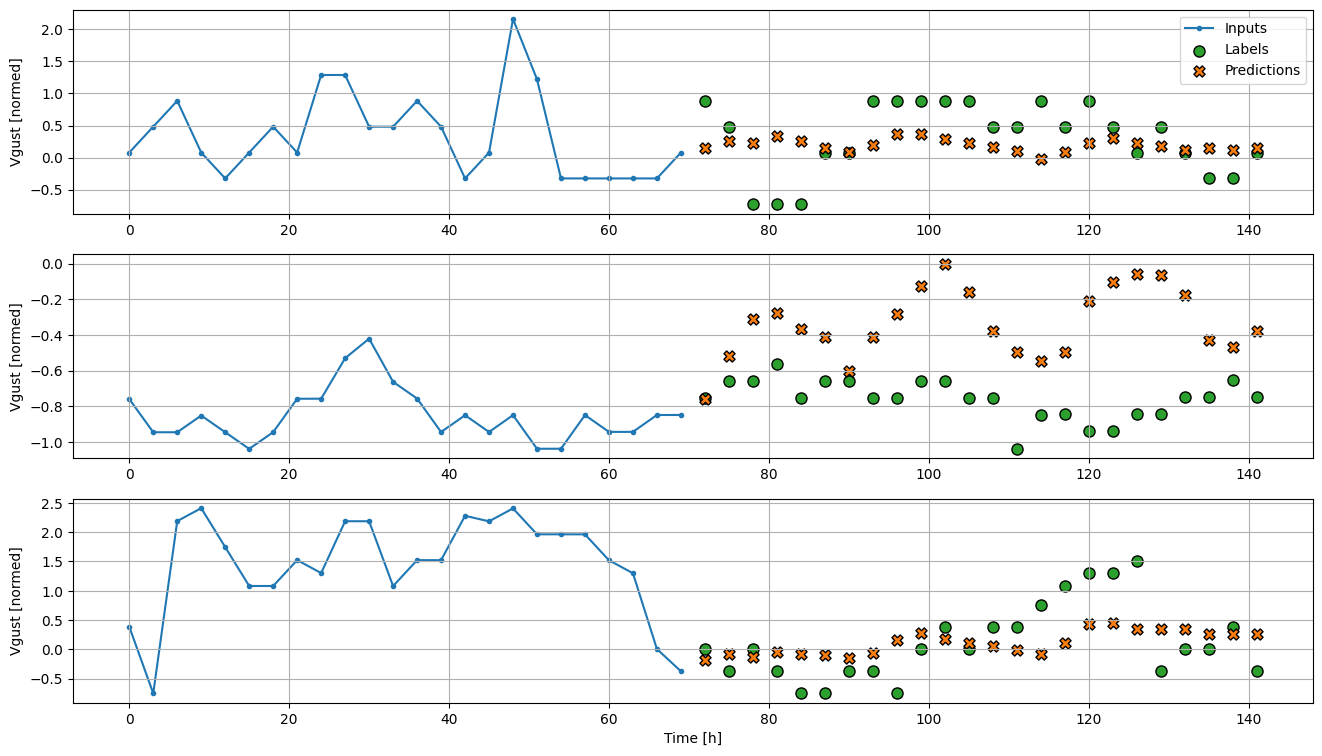

In [151]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN
Рекуррентная модель может научиться использовать историю входных данных. Эта модель будет накапливать внутреннее состояние в течение 24 часов, прежде чем сделать единичный прогноз на следующие 24 часа.

В этом однократном формате LSTM должен выдавать результат только на последнем временном шаге, поэтому установите `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](pics/multistep_lstm.png)


<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
120/120 [==============================] - 0s 2ms/step - loss: 0.5490 - mean_absolute_error: 0.5152


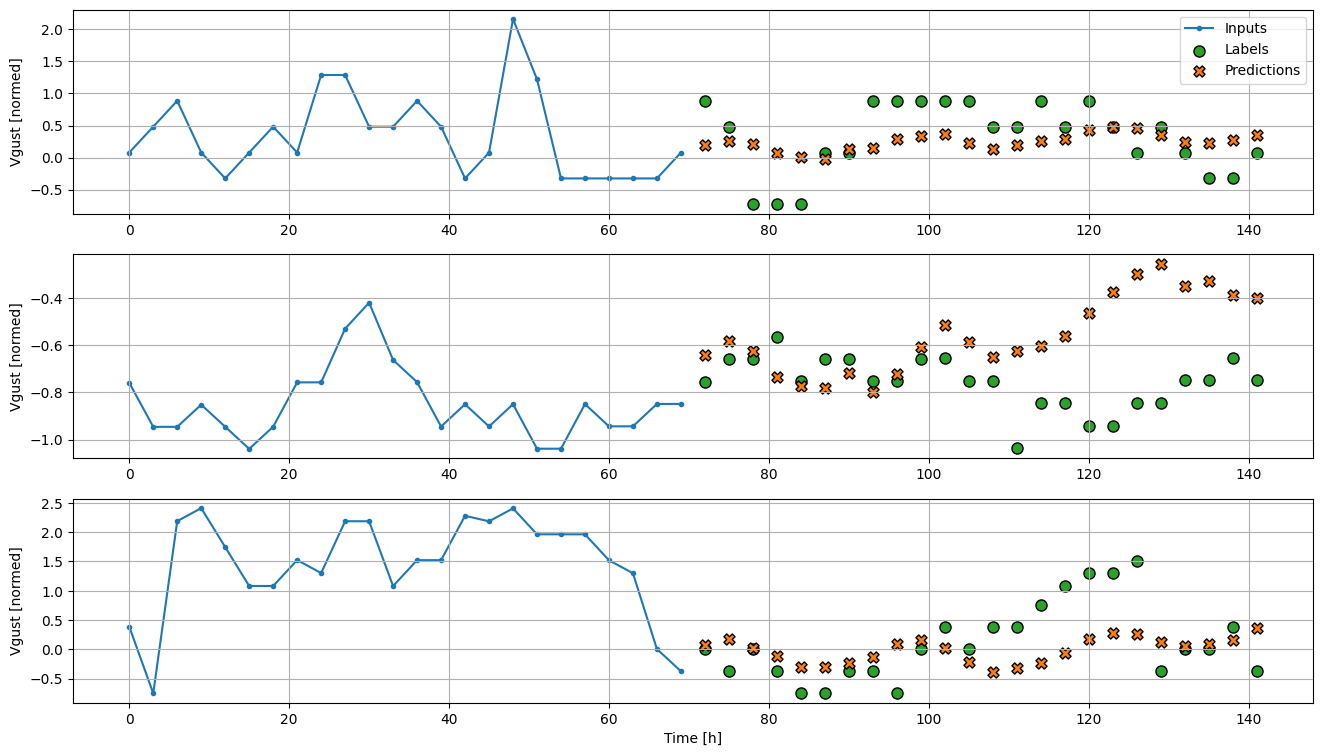

In [152]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Дополнительно: Ауторегрессивная модель

Все вышеперечисленные модели предсказывают всю выходную последовательность за один шаг.

В некоторых случаях модели может быть полезно разложить этот прогноз на отдельные временные шаги. Затем выходные данные каждой модели могут быть возвращены в себя на каждом этапе, и прогнозы могут быть сделаны с учетом предыдущего, как в классическом [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

Одним из явных преимуществ этого стиля модели является то, что ее можно настроить для выхода различной длины.

Вы можете взять любую из одношаговых моделей с несколькими выходами, обученных в первой половине этого руководства, и запустить в цикле авторегрессионной обратной связи, но здесь мы построим модель специально для этого.

![Feedback a model's output to its input](pics/multistep_autoregressive.png)


#### RNN

В этом руководстве создается только авторегрессивная модель RNN, но этот шаблон можно применить к любой модели, которая была разработана для вывода одного временного шага.

Модель будет иметь ту же базовую форму, что и одношаговые модели LSTM: LSTM, за которым следует «Layers.Dense», который преобразует выходные данные `LSTM` в прогнозы модели.

`Layers.LSTM` - это `Layers.LSTMCell`, заключенный в `Layers.RNN` более высокого уровня, который управляет состоянием и результатами последовательности для вас (см. [Keras RNNs](https://www.tensorflow.org/guide/keras/rnn)).

В этом случае модель должна вручную управлять входными данными для каждого шага, поэтому она использует `Layers.LSTMCell` непосредственно для нижнего уровня, интерфейса единственного временного шага.

In [153]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [154]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

Первый метод, который необходим этой модели, - это метод «разогрева» для инициализации ее внутреннего состояния на основе входных данных. После обучения это состояние будет фиксировать соответствующие части истории ввода. Это эквивалентно одношаговой модели LSTM, описанной ранее:

In [155]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

Этот метод возвращает прогноз одного временного шага и внутреннее состояние LSTM:

In [156]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 69])

С состоянием «RNN» и начальным прогнозом теперь вы можете продолжить итерацию модели, подавая прогнозы на каждом шаге назад в качестве входных данных.

Самый простой подход к сбору прогнозов вывода - использовать список Python и tf.stack после цикла.

Примечание. Подобное объединение списка Python работает только с нетерпеливым исполнением, с использованием Model.compile (..., run_eagerly = True) для обучения или с выводом фиксированной длины. Для длины динамического вывода вам нужно будет использовать tf.TensorArray вместо списка python и tf.range вместо  питоноского range.

In [157]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                              training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

Тестовый запуск этой модели на примерах входных данных:

In [158]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 69)


Теперь обучим модель:

<BatchDataset element_spec=TensorSpec(shape=(None, None, 69), dtype=tf.float32, name=None)>
120/120 [==============================] - 0s 3ms/step - loss: 13.9893 - mean_absolute_error: 3.0752


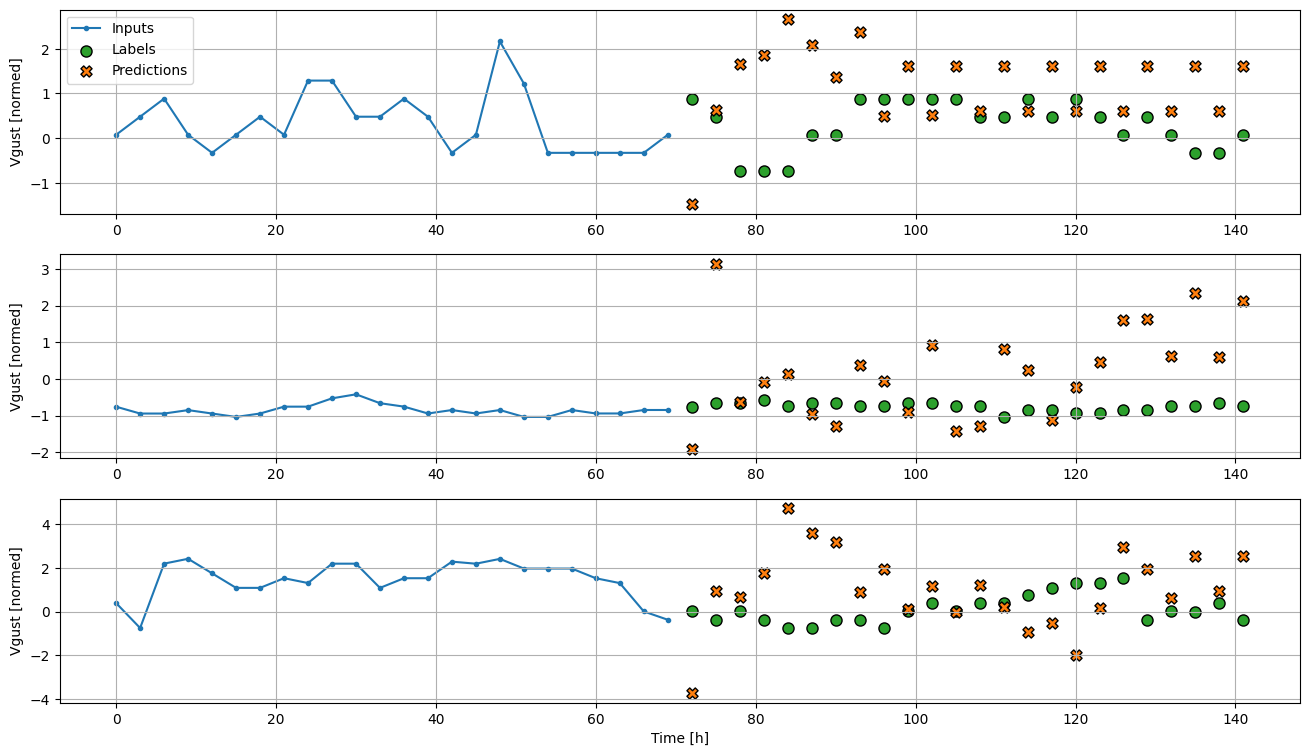

In [159]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Производительность

Очевидно, что вклад проблемы уменьшается в зависимости от сложности модели.

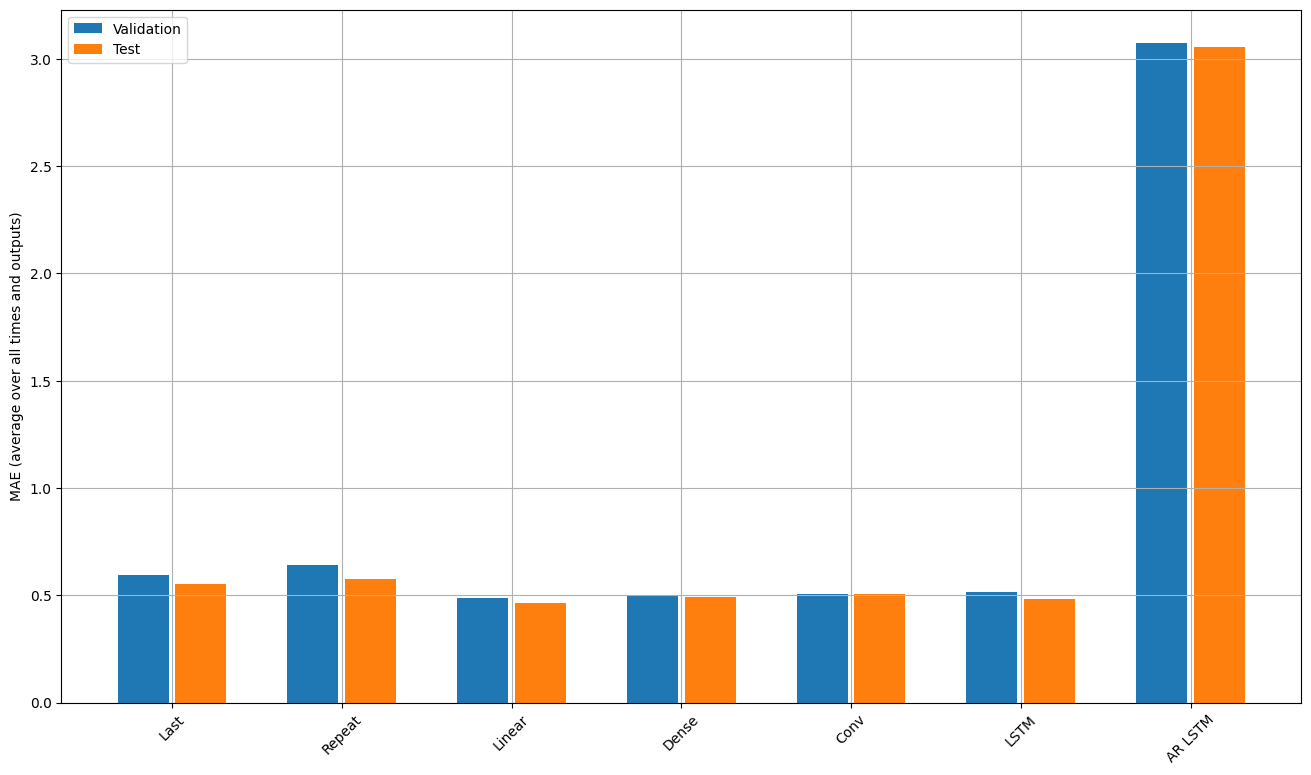

In [160]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [161]:
usefulDF.count()

T             19412
ff10_34949    19412
Vgust         19412
N_34949       19412
Td_34949      19412
              ...  
Wy_37031      19412
Day sin       19412
Day cos       19412
Year sin      19412
Year cos      19412
Length: 69, dtype: int64

In [162]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5548
Repeat  : 0.5739
Linear  : 0.4631
Dense   : 0.4930
Conv    : 0.5064
LSTM    : 0.4832
AR LSTM : 3.0525


# Определение размерности

In [163]:
usefulDF.isnull().values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [164]:
usefulDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19412 entries, 2011-10-26 15:00:00 to 2020-01-01 21:00:00
Data columns (total 69 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   T           19412 non-null  float64
 1   ff10_34949  19412 non-null  float64
 2   Vgust       19412 non-null  float64
 3   N_34949     19412 non-null  float64
 4   Td_34949    19412 non-null  float64
 5   Po_34949    19412 non-null  float64
 6   P_34949     19412 non-null  float64
 7   Tn_34949    19412 non-null  float64
 8   Tx_34949    19412 non-null  float64
 9   VV_34949    19412 non-null  float64
 10  RRR_34949   19412 non-null  float64
 11  Wx_34949    19412 non-null  float64
 12  Wy_34949    19412 non-null  float64
 13  T_34945     19412 non-null  float64
 14  ff10_34945  19412 non-null  float64
 15  ff3_34945   19412 non-null  float64
 16  N_34945     19412 non-null  float64
 17  Td_34945    19412 non-null  float64
 18  Po_34945    19412 non-null  flo

In [165]:
# Удаляем одинаковые строки в данных (иначе не будет работать)

from copy import copy
usefulDF1=copy(usefulDF)

usefulDF1=usefulDF1.drop_duplicates(keep = 'first', inplace = False)

Посмотрим внутреннюю размерность для датасета usefulDF содержащего метеоданные соседних станций

In [166]:
import skdim
danco0 = skdim.id.DANCo().fit(usefulDF1)
lpca0 = skdim.id.lPCA().fit_pw(usefulDF1,
                              n_neighbors = 100,
                              n_jobs = 1)
print("dimension:",danco0.dimension_)
print("lpca_mean:",np.mean(lpca0.dimension_pw_))


dimension: 10.00139479527489
lpca_mean: 14.894498248506078


Создадим датасет, убрав данные с одной из соседних метеостанций

In [167]:
usefulDF1 = M1.MeteoDf[forecastList[0]]
for st in forecastList[1:-1]:
    usefulDF1 = usefulDF1.join(M1.MeteoDf[st],on='Date Time',how='inner')
    print(st)
addPeriodic(usefulDF1)

34945
37036
34954


In [168]:
danco1 = skdim.id.DANCo().fit(usefulDF1.dropna())
lpca1 = skdim.id.lPCA().fit_pw(usefulDF1.dropna(),
                              n_neighbors = 100,
                              n_jobs = 1)
print(danco1.dimension_, np.mean(lpca1.dimension_pw_))

10.002393374189538 13.530984391902333


Внутренняя размерность изменилась слабо

Уберем из датасета другую метеостанцию

In [169]:
usefulDF2 = M1.MeteoDf[forecastList[0]]
for st in forecastList[2:]:
    usefulDF2 = usefulDF2.join(M1.MeteoDf[st],on='Date Time',how='inner')
    print(st)
addPeriodic(usefulDF2)

37036
34954
37031


In [170]:
danco2 = skdim.id.DANCo().fit(usefulDF2.dropna())
lpca2 = skdim.id.lPCA().fit_pw(usefulDF2.dropna(),
                              n_neighbors = 100,
                              n_jobs = 1)
print(danco2.dimension_, np.mean(lpca2.dimension_pw_))

12.004263433697487 14.117669459253618


Здесь же мы видим изменение внутренней размерности, что говорит о большей значимости отсеянной метеостанции. Таким образом исключать данную станцию нельзя.

Выберем теперь два подпространства признаков.
Первое подпространство состоит из:
- температуры воздуха в градусах Цельсия на высоте 2 м над поверхностью земли,
- атмосферного давления, приведенного к среднему уровню моря (в мм.рт.ст.),
- максимального значения порыва ветра на высоте 10-12 м над земной поверхностью за период между сроками (м/с).

Второе подпространство признаков состоит из:
- признака общей облачности,
- горизонтальной дальности видимости (км),
- количества выпавших осадков (мм).
Если первое подпространство признаков состоит из равномерно распределенных величин, то второе состоит из одного категориального признака, одного дискретного признака с малой вариативностью и непрерывного признака.

In [171]:
# НЕ НАДО ДЕЛАТЬ dropna(), ОНИ УЖЕ УСТРАНЕНЫ

names1=['T', 'P_34949', 'Vgust']
names2=['N_34949', 'VV_34949', 'RRR_34949']
data1 = usefulDF[names1].to_numpy()#[:100]
data2 = usefulDF[names2].to_numpy()#[:100]

Text(0.5, 0, 'RRR_34949')

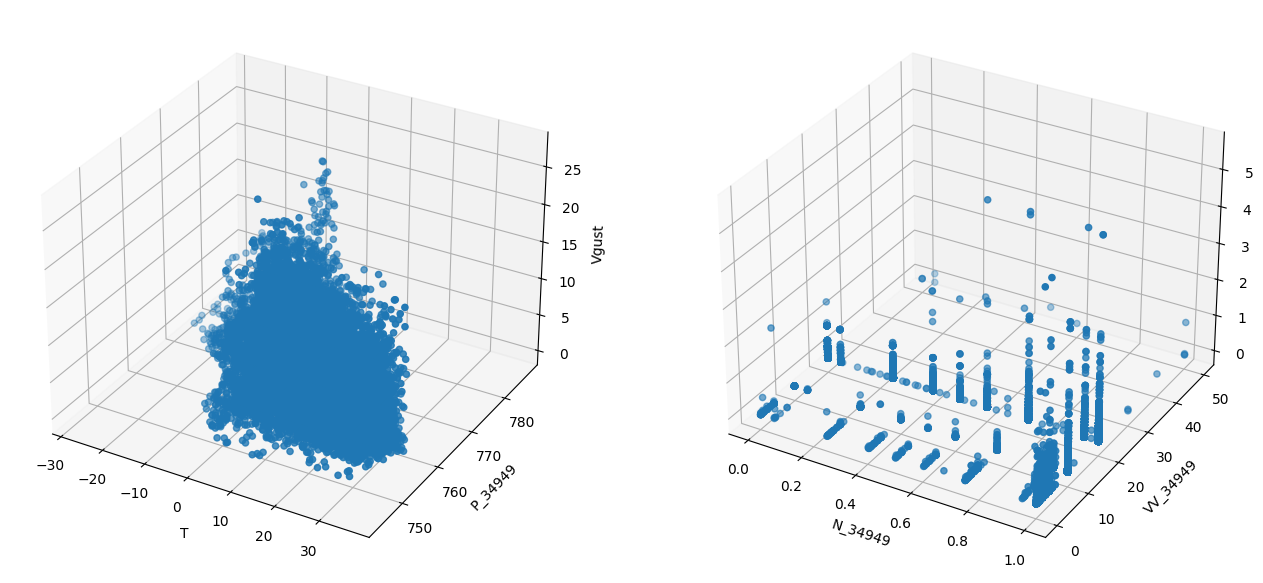

In [172]:
fig = plt.figure(figsize=plt.figaspect(0.5))
#ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(data1[:,0],data1[:,1],data1[:,2])
ax.set_xlabel(names1[0]);ax.set_ylabel(names1[1]);ax.set_zlabel(names1[2])
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(data2[:,0],data2[:,1],data2[:,2])
ax.set_xlabel(names2[0]);ax.set_ylabel(names2[1]);ax.set_zlabel(names2[2])

In [173]:
pca=skdim.id.lPCA()

#global ID
gid1=pca.fit(data1).dimension_
gid2=pca.fit(data2).dimension_
print(gid1,gid2)

3 1


In [174]:
#local ID (pointwise estimates)
lid1=pca.fit_pw(data1,n_neighbors=25).dimension_pw_
lid2=pca.fit_pw(data2,n_neighbors=25).dimension_pw_

Text(0.5, 0, 'RRR_34949')

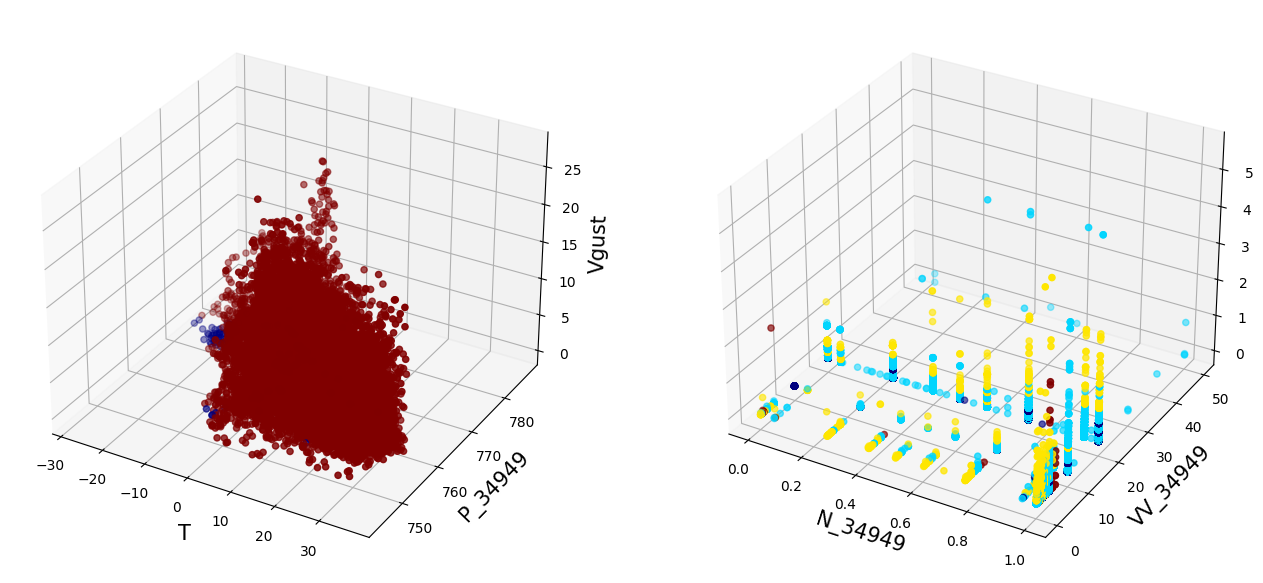

In [175]:
fig = plt.figure(figsize=plt.figaspect(0.5))
fs=15 # размер шрифта подписей
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(data1[:,0],data1[:,1],data1[:,2],c=lid1,cmap='jet')
ax.set_xlabel(names1[0],fontsize=fs);ax.set_ylabel(names1[1],fontsize=fs);ax.set_zlabel(names1[2],fontsize=fs)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(data2[:,0],data2[:,1],data2[:,2],c=lid2,cmap='jet')
ax.set_xlabel(names2[0],fontsize=fs);ax.set_ylabel(names2[1],fontsize=fs);ax.set_zlabel(names2[2],fontsize=fs)

Здесь мы видим, что первое подпространство признаков, показанное слева, разделилось на 2 класса, один из которых содержит большую часть точек выборки, и второй класс с некоторыми обособленными точками нулевого значения скорости порывов ветра.
Второе подпространство признаков поделилось на 4 класса, по градиентам величин горизонтальной дальности видимости и количеству выпавших осадков. Стоит отметить, что эти два параметра взаимосвязаны, так как во время увеличения количества выпадаемых осадков падает видимость.

In [176]:
# Завершение работы с ноутбуком

In [177]:
# Остановка tensorboard в Linux

In [178]:
# !kill$(ps-e)|grep 'tensorboard'|awk'{print$1}') 

In [179]:
# В MS Windows выполнить "Restart Kernel" 